In [1]:
library(Seurat)
library(dplyr)
library(patchwork)
library(harmony)
library(future)
library(ggplot2)
library(trqwe)
library(unix)
library(readr)
library(SingleCellExperiment)
library(scuttle)
library(reshape2)
library(rmcorr)
library(data.table)
library(edgeR)
library(gghalves)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

Warning message:
“package ‘readr’ was built under R version 4.1.3”
Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, 

In [3]:
setwd("/rds/general/user/emacdona/projects/covid19-transcriptome/live/sc_rnaseq/olink_CA")

In [48]:
data<-mcreadRDS("../all_compartments_olink_qc_RNA.rds", mc.cores = 4)

In [49]:
# cite markers
markers<-fread("CITE_markers.txt",data.table=FALSE,header=FALSE)

In [50]:
head(markers)

V1    
1 ADGRG1
2 ANPEP 
3 B3GAT1
4 BTLA  
5 C5AR1 
6 CCR4

In [52]:
#need to make it just the samples with olink
#need to read in the olink file
olink<-read.csv("../olink_data/plasma_npx_level.csv")

In [53]:
head(olink)

Original_SampleID SampleID Individual_ID UniProt GeneID Assay NPX     Panel
1 C60_1905          C60_1    C60           P42785  PRCP   PRCP  1.61180 CM   
2 C31_1704          C31_2    C31           P42785  PRCP   PRCP  1.42770 CM   
3 C60_2104          C60_3    C60           P42785  PRCP   PRCP  1.01689 CM   
4 C10_1004          C10_6    C10           P42785  PRCP   PRCP  1.37725 CM   
5 C114_1905         C114_7   C114          P42785  PRCP   PRCP  1.97878 CM   
6 C60_2804          C60_8    C60           P42785  PRCP   PRCP  1.37635 CM   
  Index
1 1    
2 2    
3 3    
4 6    
5 7    
6 8

In [54]:
length(unique(olink$Original_SampleID[olink$Original_SampleID%in%data$sample_id]))

[1] 85

In [55]:
length(unique(data$sample_id[data$sample_id%in%olink$Original_SampleID]))

[1] 85

In [58]:
length(unique(olink$Individual_ID[olink$Individual_ID%in%data$individual_id]))

[1] 45

In [59]:
prots<-unique(olink$GeneID)

In [60]:
data

An object of class Seurat 
32913 features across 371084 samples within 1 assay 
Active assay: RNA (32913 features, 2000 variable features)
 7 dimensional reductions calculated: pca_RNA, umapBeforeHarmony_RNA, harmony_RNA, umapAfterHarmony_RNA, pca, harmony, umap_harmony_new

In [62]:
unique(data$level_1)

[1] "monocyte" "T reg"    "DC"       "T CD4+"   "NK"       "T CD8+"  
 [7] "RBC"      "B"        "MAIT"     "T g/d"    "B_ASC"    "Platelet"
[13] "HSPC"

In [63]:
mono<-subset(data,subset=level_1=="monocyte")

In [64]:
mono

An object of class Seurat 
32913 features across 46595 samples within 1 assay 
Active assay: RNA (32913 features, 2000 variable features)
 7 dimensional reductions calculated: pca_RNA, umapBeforeHarmony_RNA, harmony_RNA, umapAfterHarmony_RNA, pca, harmony, umap_harmony_new

In [65]:
data<-as.SingleCellExperiment(mono)


In [66]:
sce<-data

sce$individual_id<-factor(sce$individual_id)
sce$sample_id<-factor(sce$sample_id)
sce$ethnicity<-factor(sce$ethnicity)
sce$sex<-factor(sce$sex)
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age


In [67]:
min_cells=10

In [68]:
nCells <- table(sce$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
rm_ids<-c("C116","C139")
sce1 <- sce[, !sce$sample_id %in% rmSamples & !sce$individual_id %in% rm_ids]


In [69]:
smrzd <- aggregateAcrossCells(sce1, id = as.character(colData(sce1)[, c("sample_id")]))
smrzd <- smrzd[, smrzd$case_control == "POSITIVE"]


In [70]:
names(colData(smrzd))[names(colData(smrzd))%in%prots]<-paste0("olink_",names(colData(smrzd))[names(colData(smrzd))%in%prots])

In [71]:
"WHO_temp_severity_group"%in%names(colData(smrzd))

[1] TRUE

In [72]:
#plotExpression(smrzd,"olink_CD163",x="WHO_temp_severity_group")

In [73]:
head(data.frame(colData(smrzd))[,c("WHO_temp_severity_group","olink_CD163")])

WHO_temp_severity_group olink_CD163
C113_0605 mild_moderate           8.66137    
C113_2304 severe_critical         8.56608    
C113_2904 severe_critical         8.78959    
C123_0505 mild_moderate           9.03569    
C123_2404 severe_critical         7.89662    
C123_2904 severe_critical         8.25967

In [75]:
library(viridis)

In [83]:
###################
# Correlation of TNF
##################

In [84]:
df1<-data.frame(t(counts(smrzd)))

In [85]:
wide_olink<-dcast(olink,Original_SampleID~GeneID,value.var="NPX")
names(wide_olink)[1]<-"sample_id"

Warning message in dcast(olink, Original_SampleID ~ GeneID, value.var = "NPX"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(olink). In the next version, this warning will become an error.”


In [86]:
head(df1)

MIR1302.2HG FAM138A OR4F5 AL627309.1 AL627309.3 AL627309.2 AL627309.4
C113_0605 0           0       0     0.000000   0          0          0         
C113_2304 0           0       0     0.000000   0          0          0         
C113_2904 0           0       0     1.000000   0          0          0         
C123_0505 0           0       0     2.000000   0          0          0         
C123_2404 0           0       0     0.000000   1          0          0         
C123_2904 0           0       0     2.922208   0          0          0         
          AL732372.1 OR4F29 AC114498.1 ⋯ AC007325.2 BX072566.1 AL354822.1
C113_0605 0          0      0          ⋯ 0          0          0.9220705 
C113_2304 0          0      0          ⋯ 0          0          0.0000000 
C113_2904 0          0      0          ⋯ 0          0          1.9522522 
C123_0505 0          0      0          ⋯ 0          0          0.9262443 
C123_2404 0          0      0          ⋯ 0          0          0.9982740 
C123_2904 0          0      0          ⋯ 0          0          0.9886135 
          AC023491.2 AC004556.1 AC233755.2 AC233755.1 AC240274.1 AC213203.1
C113_0605 0          0.0000000  0          0.0000000  0.0000000  0         
C113_2304 0          0.0000000  0          0.0000000  0.0000000  0         
C113_2904 0          0.0000000  0          0.0000000  5.9566730  0         
C123_0505 0          0.0000000  0          0.0000000  0.9906943  0         
C123_2404 0          2.9335922  0          0.0000000  1.0000000  0         
C123_2904 0          0.9896266  0          0.3494962  6.9949056  0         
          FAM231C
C113_0605 0      
C113_2304 0      
C113_2904 0      
C123_0505 0      
C123_2404 0      
C123_2904 0

In [87]:
head(wide_olink)

sample_id ACE2    ACP5    ADA     ADAMTS13 ADM     AGER     AGRP    ALCAM  
1 C10_0904  4.31942 5.22099 6.59515 5.02047  9.63987 14.28654 8.54856 6.87146
2 C10_1004       NA 5.42460 6.22122      NA       NA       NA      NA 6.95265
3 C10_1304  5.48073 5.31722 8.47996 4.80678  9.76965 14.56124 9.31073 6.84951
4 C10_1504  5.84539 5.75672 6.74048 4.49147  9.53601 14.38560 8.96045 6.94665
5 C10_1804  5.81408 6.41364 6.19165 4.45442  9.43464 14.30827 9.22595 7.17486
6 C10_2704  4.52625 5.46851 6.15581 4.70366  9.43217 14.35600 8.69486 7.15919
  AMBP    ⋯ TRIM21  TRIM5   TSLP    UMOD    VASN    VCAM1   VEGFA    VSIG2  
1 8.35212 ⋯ 4.86229 4.52733 1.81250 0.84878 1.36621 5.58367 13.54046 6.81049
2      NA ⋯ 4.13485 3.02618 1.68788 1.01628 2.08902 6.46439 13.29913      NA
3 8.32613 ⋯ 7.38078 6.13364 2.33945 0.46825 1.69350 5.93342 14.22140 6.76613
4 7.92587 ⋯ 5.02021 5.00126 2.80748 0.80058 1.49240 5.91712 13.40587 6.44896
5 7.86669 ⋯ 3.76763 3.98884 2.69777 0.60706 1.98222 6.19642 13.03335 6.56339
6 8.05567 ⋯ 2.83557 2.97988 1.62605 0.84609 2.22331 6.03565 13.06735 7.11425
  VWF     ZBTB16 
1 8.52735 3.30696
2 7.91815 2.62981
3 8.13753 6.83428
4 8.66705 4.84732
5 8.19562 3.49489
6 6.52932 2.16255

In [88]:
names(wide_olink)[names(wide_olink)!="sample_id"]<-paste0("olink_",names(wide_olink)[names(wide_olink)!="sample_id"])

df1$sample_id<-rownames(df1)



In [89]:
new4<-merge(df1,wide_olink,by="sample_id",all.x=TRUE)
head(new4)
dim(new4)


sample_id MIR1302.2HG FAM138A OR4F5 AL627309.1 AL627309.3 AL627309.2
1 C113_0605 0           0       0     0.000000   0          0         
2 C113_2304 0           0       0     0.000000   0          0         
3 C113_2904 0           0       0     1.000000   0          0         
4 C123_0505 0           0       0     2.000000   0          0         
5 C123_2404 0           0       0     0.000000   1          0         
6 C123_2904 0           0       0     2.922208   0          0         
  AL627309.4 AL732372.1 OR4F29 ⋯ olink_TRIM21 olink_TRIM5 olink_TSLP olink_UMOD
1 0          0          0      ⋯ 2.39262      2.88367     0.98505    0.47552   
2 0          0          0      ⋯ 3.19469      2.61469     1.22499    0.89623   
3 0          0          0      ⋯ 2.50348      2.33191     0.56714    0.85136   
4 0          0          0      ⋯ 3.16216      2.58440     1.90829    0.65588   
5 0          0          0      ⋯ 5.33566      3.34280     1.19536    0.99021   
6 0          0          0      ⋯ 4.45995      3.71140     0.78107    0.74773   
  olink_VASN olink_VCAM1 olink_VEGFA olink_VSIG2 olink_VWF olink_ZBTB16
1 2.81779    6.11572     12.99018    6.36287     6.49356   3.00130     
2 2.66852    6.77634     13.14894    6.18068     6.40599   1.98728     
3 2.75854    6.67321     13.22140    6.30056     6.88699   2.66870     
4 2.61126    6.70030     13.48759    6.79532     8.25741   3.79134     
5 1.96722    6.86766     13.72498    6.39523     8.03510   3.87227     
6 2.31079    6.55284     13.58713    6.72219     8.38920   5.68196

[1]    57 33350

In [90]:
new4$individual_id<-gsub("_[0-9]+","",new4$sample_id)

In [92]:
head(new4)

sample_id MIR1302.2HG FAM138A OR4F5 AL627309.1 AL627309.3 AL627309.2
1 C113_0605 0           0       0     0.000000   0          0         
2 C113_2304 0           0       0     0.000000   0          0         
3 C113_2904 0           0       0     1.000000   0          0         
4 C123_0505 0           0       0     2.000000   0          0         
5 C123_2404 0           0       0     0.000000   1          0         
6 C123_2904 0           0       0     2.922208   0          0         
  AL627309.4 AL732372.1 OR4F29 ⋯ olink_TRIM5 olink_TSLP olink_UMOD olink_VASN
1 0          0          0      ⋯ 2.88367     0.98505    0.47552    2.81779   
2 0          0          0      ⋯ 2.61469     1.22499    0.89623    2.66852   
3 0          0          0      ⋯ 2.33191     0.56714    0.85136    2.75854   
4 0          0          0      ⋯ 2.58440     1.90829    0.65588    2.61126   
5 0          0          0      ⋯ 3.34280     1.19536    0.99021    1.96722   
6 0          0          0      ⋯ 3.71140     0.78107    0.74773    2.31079   
  olink_VCAM1 olink_VEGFA olink_VSIG2 olink_VWF olink_ZBTB16 individual_id
1 6.11572     12.99018    6.36287     6.49356   3.00130      C113         
2 6.77634     13.14894    6.18068     6.40599   1.98728      C113         
3 6.67321     13.22140    6.30056     6.88699   2.66870      C113         
4 6.70030     13.48759    6.79532     8.25741   3.79134      C123         
5 6.86766     13.72498    6.39523     8.03510   3.87227      C123         
6 6.55284     13.58713    6.72219     8.38920   5.68196      C123

In [93]:
#head(data.frame(colData(smrzd)))
"sample_id"%in%names(colData(smrzd))

[1] TRUE

In [94]:
dim(data.frame(colData(smrzd)))
dim(new4)

[1]  57 616

[1]    57 33351

In [95]:
new5<-merge(new4,data.frame(colData(smrzd)[,c("sample_id","WHO_temp_severity_group")]),by="sample_id",all.x=TRUE)
head(new5)
dim(new5)

sample_id MIR1302.2HG FAM138A OR4F5 AL627309.1 AL627309.3 AL627309.2
1 C113_0605 0           0       0     0.000000   0          0         
2 C113_2304 0           0       0     0.000000   0          0         
3 C113_2904 0           0       0     1.000000   0          0         
4 C123_0505 0           0       0     2.000000   0          0         
5 C123_2404 0           0       0     0.000000   1          0         
6 C123_2904 0           0       0     2.922208   0          0         
  AL627309.4 AL732372.1 OR4F29 ⋯ olink_TSLP olink_UMOD olink_VASN olink_VCAM1
1 0          0          0      ⋯ 0.98505    0.47552    2.81779    6.11572    
2 0          0          0      ⋯ 1.22499    0.89623    2.66852    6.77634    
3 0          0          0      ⋯ 0.56714    0.85136    2.75854    6.67321    
4 0          0          0      ⋯ 1.90829    0.65588    2.61126    6.70030    
5 0          0          0      ⋯ 1.19536    0.99021    1.96722    6.86766    
6 0          0          0      ⋯ 0.78107    0.74773    2.31079    6.55284    
  olink_VEGFA olink_VSIG2 olink_VWF olink_ZBTB16 individual_id
1 12.99018    6.36287     6.49356   3.00130      C113         
2 13.14894    6.18068     6.40599   1.98728      C113         
3 13.22140    6.30056     6.88699   2.66870      C113         
4 13.48759    6.79532     8.25741   3.79134      C123         
5 13.72498    6.39523     8.03510   3.87227      C123         
6 13.58713    6.72219     8.38920   5.68196      C123         
  WHO_temp_severity_group
1 mild_moderate          
2 severe_critical        
3 severe_critical        
4 mild_moderate          
5 severe_critical        
6 severe_critical

[1]    57 33352

In [97]:
tnf<-new5[,c("sample_id","individual_id","WHO_temp_severity_group","TNF","olink_TNF")]

In [98]:
head(tnf)
dim(tnf)

sample_id individual_id WHO_temp_severity_group TNF         olink_TNF
1 C113_0605 C113          mild_moderate            38.8387821 3.67949  
2 C113_2304 C113          severe_critical           0.9888133 5.02108  
3 C113_2904 C113          severe_critical          86.6546016 4.61219  
4 C123_0505 C123          mild_moderate           251.3327788 4.52726  
5 C123_2404 C123          severe_critical          21.5382253 4.52166  
6 C123_2904 C123          severe_critical         146.1467841 5.88642

[1] 57  5

In [100]:
length(unique(tnf$sample_id))
length(unique(tnf$individual_id))

[1] 57

[1] 21

In [52]:
long_tnf<-melt(tnf)
head(long_tnf)

Warning message in melt(tnf):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(tnf). In the next version, this warning will become an error.”
Using sample_id, individual_id, WHO_temp_severity_group as id variables



sample_id individual_id WHO_temp_severity_group variable value      
1 C113_0605 C113          mild_moderate           TNF       38.8387821
2 C113_2304 C113          severe_critical         TNF        0.9888133
3 C113_2904 C113          severe_critical         TNF       86.6546016
4 C123_0505 C123          mild_moderate           TNF      251.3327788
5 C123_2404 C123          severe_critical         TNF       21.5382253
6 C123_2904 C123          severe_critical         TNF      146.1467841

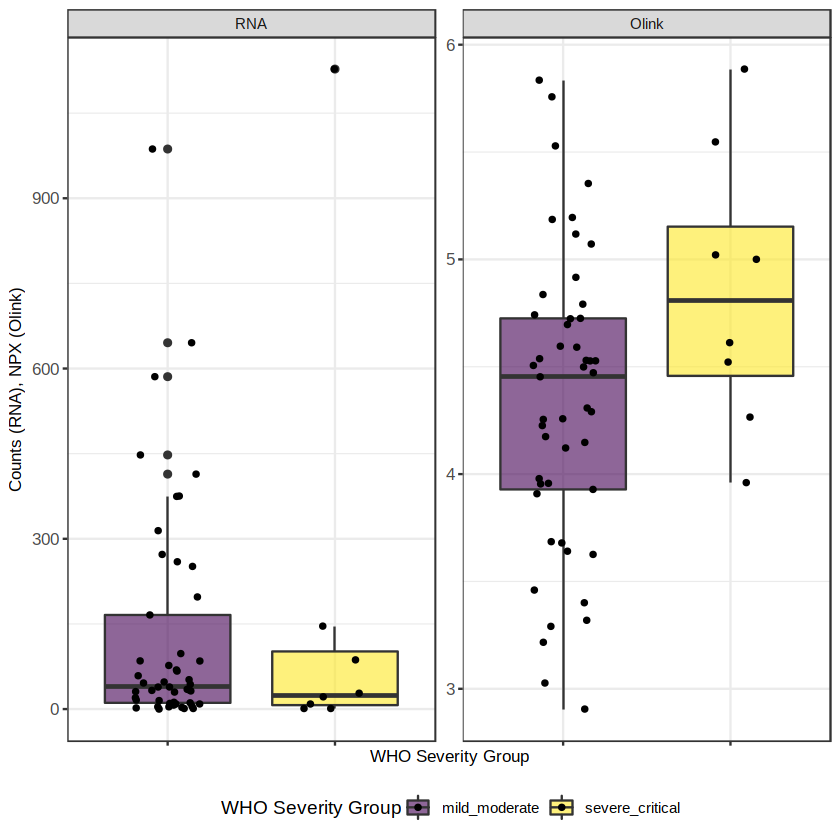

In [71]:
labels<-c("RNA","Olink")
names(labels)<-c("TNF","olink_TNF")


ggplot(long_tnf,aes(x=WHO_temp_severity_group,y=value,fill=WHO_temp_severity_group))+
    geom_boxplot()+
    scale_fill_viridis(discrete = TRUE, alpha=0.6)+ #,, option="A"
    facet_wrap(~variable,scales="free",labeller= labeller(variable=labels))+
#geom_dotplot(binaxis='y', stackdir='center', dotsize=0.4,binwidth=0.2)+
geom_jitter(shape=16, position=position_jitter(0.2))+
    xlab("WHO Severity Group") +
    ylab("Counts (RNA), NPX (Olink)") +
    labs(fill="WHO Severity Group") +
    theme_bw()+
    theme(axis.text=element_text(size=10),
        axis.text.x=element_blank(),
         axis.title=element_text(size=10),
         legend.position="bottom")
ggsave("TNF_boxplot.pdf",height=5,width=5)

In [54]:
getwd()

[1] "/rds/general/project/covid19-transcriptome/live/sc_rnaseq/olink_CA"

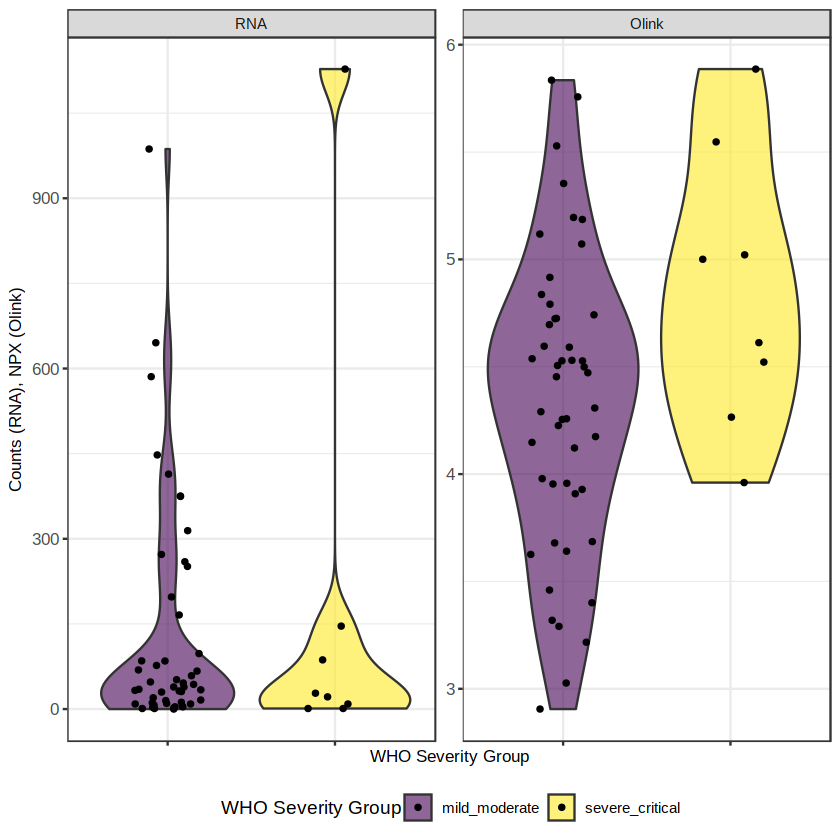

In [73]:
ggplot(long_tnf,aes(x=WHO_temp_severity_group,y=value,fill=WHO_temp_severity_group))+
    geom_violin()+
#geom_dotplot(binaxis='y', stackdir='center', dotsize=0.5)+
geom_jitter(shape=16, position=position_jitter(0.2))+
    scale_fill_viridis(discrete = TRUE, alpha=0.6)+ #,, option="A"
    facet_wrap(~variable,scales="free",labeller= labeller(variable=labels))+
xlab("WHO Severity Group") +
    ylab("Counts (RNA), NPX (Olink)") +
    labs(fill="WHO Severity Group") +
    theme_bw()+
    theme(axis.text=element_text(size=10),
        axis.text.x=element_blank(),
         axis.title=element_text(size=10),
         legend.position="bottom")
ggsave("TNF_violin.pdf",height=5,width=5)

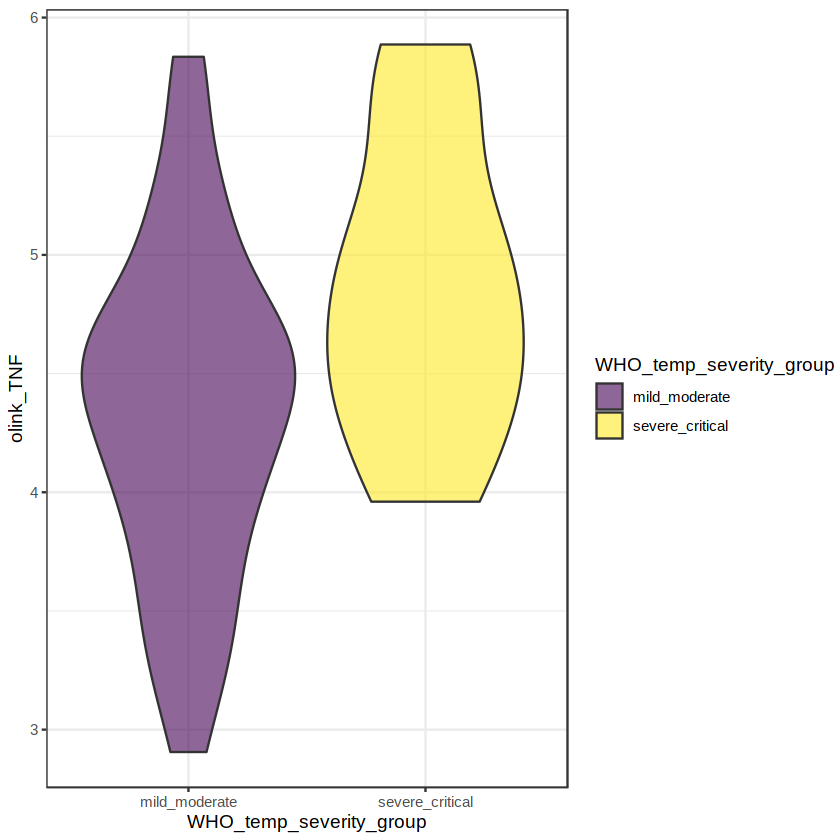

In [53]:
ggplot(new5,aes(x=WHO_temp_severity_group,y=olink_TNF,fill=WHO_temp_severity_group))+
    geom_violin()+
    scale_fill_viridis(discrete = TRUE, alpha=0.6)+ #,, option="A"
    theme_bw()

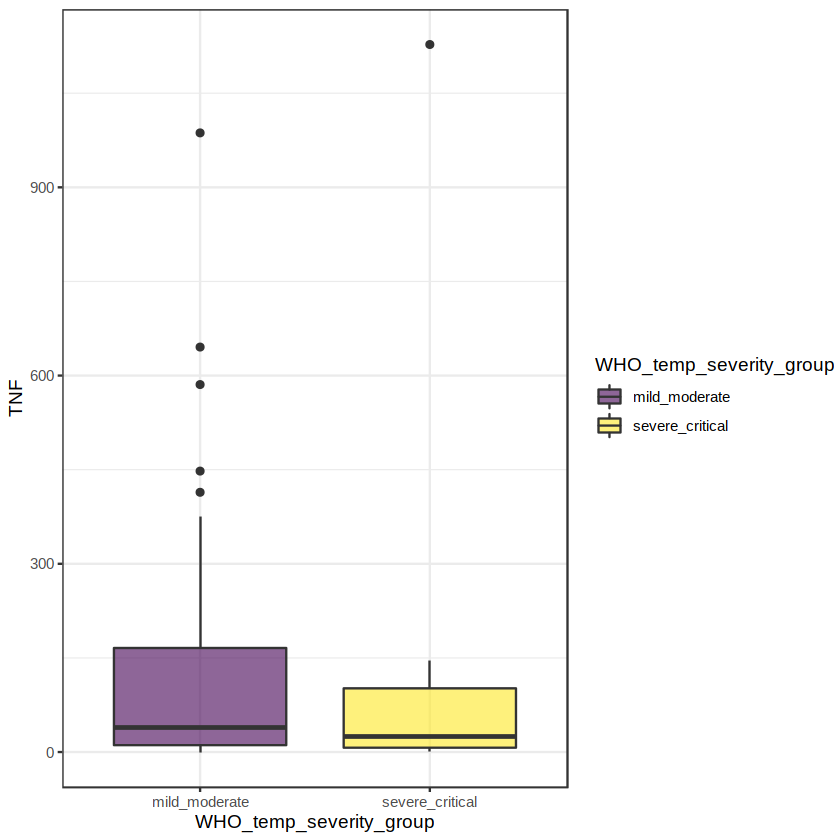

In [46]:
ggplot(new5,aes(x=WHO_temp_severity_group,y=TNF,fill=WHO_temp_severity_group))+
    geom_boxplot()+
    scale_fill_viridis(discrete = TRUE, alpha=0.6)+ #,, option="A"
    theme_bw()

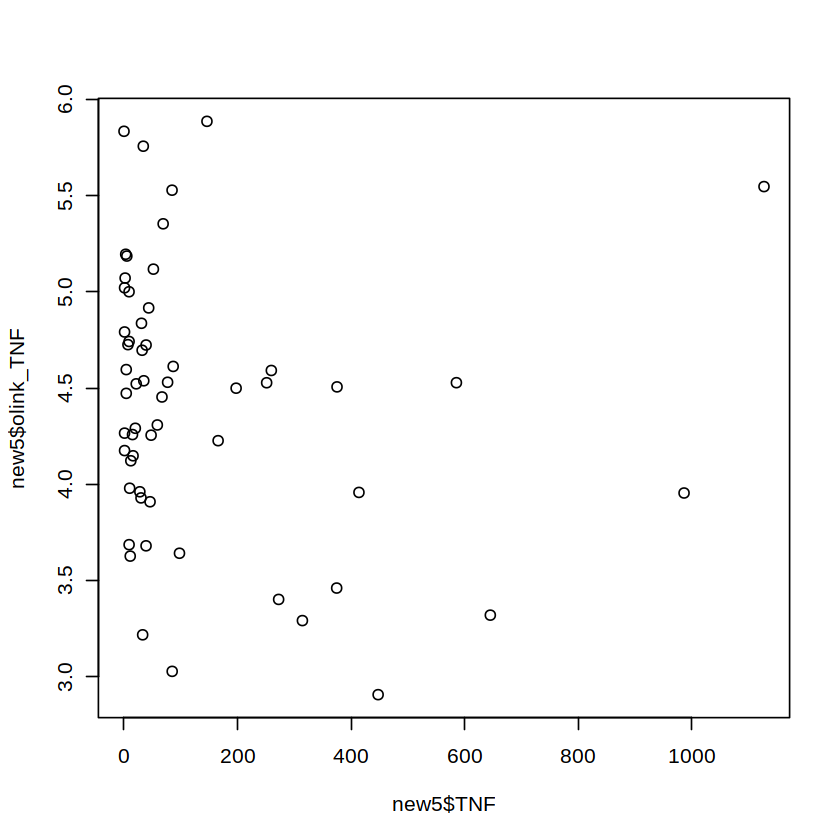

In [44]:
plot(new5$TNF,new5$olink_TNF)

In [69]:
cor.test(new5$TNF,new5$olink_TNF,method="spearman")


	Spearman's rank correlation rho

data:  new5$TNF and new5$olink_TNF
S = 39704, p-value = 0.03093
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2867514 


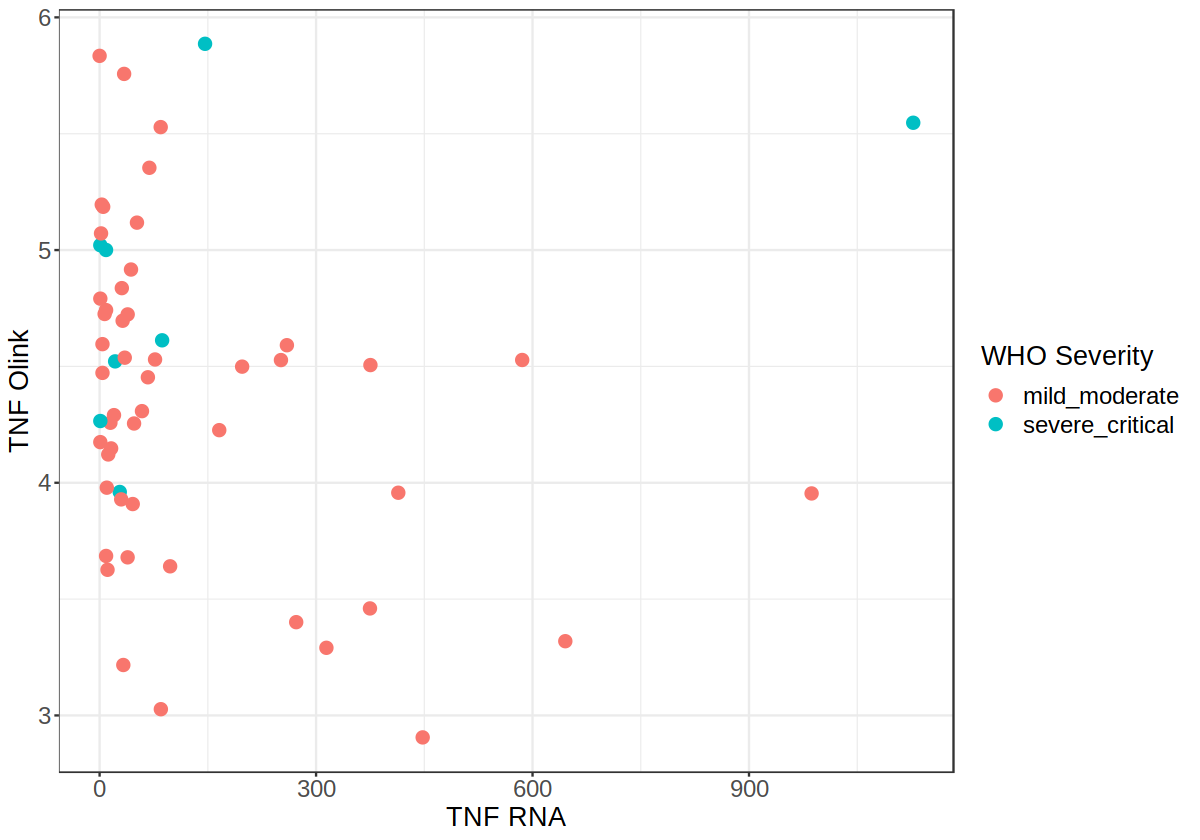

In [65]:
options(repr.plot.width=10, repr.plot.height=7)
ggplot(new5,aes(x=TNF,y=olink_TNF,colour=WHO_temp_severity_group))+
    geom_point(size=3)+
    xlab("TNF RNA")+
    ylab("TNF Olink")+
    labs(colour="WHO Severity")+
    theme_bw()+
    theme(axis.text = element_text(size = 14),
         axis.title = element_text(size = 16),
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 14))


In [66]:
options(repr.plot.width=10, repr.plot.height=7)
ggplot(new5,aes(x=MCEMP1,y=olink_MCEMP1,colour=WHO_temp_severity_group))+
    geom_point(size=3)+
    xlab("MCEMP1 RNA")+
    ylab("MCEMP1 Olink")+
    labs(colour="WHO Severity")+
    theme_bw()+
    theme(axis.text = element_text(size = 14),
         axis.title = element_text(size = 16),
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 14))


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'olink_MCEMP1' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.output(

In [13]:
#########
#
#########

In [18]:
length(unique(data$sample_id))

[1] 84

In [19]:
min_cells<-10
# Remove samples with less than MIN
nCells <- table(data$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
data <- data[,!data$sample_id %in% rmSamples]


In [20]:
length(unique(data$sample_id))

[1] 81

In [21]:
data

class: SingleCellExperiment 
dim: 32913 46579 
metadata(0):
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(0):
colnames(46579): UK-CIC10689738+UK-CIC10690026_AAACCTGAGGCAATTA-1
  UK-CIC10689738+UK-CIC10690026_AAACCTGCATCCCACT-1 ...
  UK-CIC10689787+UK-CIC10690075_TTGGAACCAATGGAGC-1
  UK-CIC10689787+UK-CIC10690075_TTTACTGTCCATGCTC-1
colData names(609): orig.ident nCount_RNA ... percent.mt ident
reducedDimNames(7): PCA_RNA UMAPBEFOREHARMONY_RNA ... HARMONY
  UMAP_HARMONY_NEW
mainExpName: RNA
altExpNames(0):

In [22]:
"individual_id"%in%names(colData(data))

[1] TRUE

In [23]:
#data$individual_id<-gsub("_[0-9]+","",data$sample_id)

In [23]:
rm_ids<-c("C116","C139")
data <- data[, !data$individual_id %in% rm_ids]


In [24]:
length(unique(data$sample_id))

[1] 81

In [25]:
smrzd <- aggregateAcrossCells(data, id=as.character(colData(data)[,c("sample_id")]))


In [27]:
#want the percentage that are 0 in rach row and each column

In [26]:
df<-data.frame(counts(smrzd))

In [27]:
df$total_zero<-rowSums(df== 0)

In [28]:
head(df)

C103_2204 C104_2204 C106_2204 C113_0605 C113_2304 C113_2904
MIR1302-2HG 0         0.000000  0.0000000 0         0         0        
FAM138A     0         0.000000  0.0000000 0         0         0        
OR4F5       0         0.000000  0.0000000 0         0         0        
AL627309.1  3         4.809967  0.9889385 0         0         1        
AL627309.3  0         0.000000  0.0000000 0         0         0        
AL627309.2  0         0.000000  0.0000000 0         0         0        
            C123_0505 C123_2404 C123_2904 C124_0105 ⋯ C69_1804 C73_2004
MIR1302-2HG 0         0         0.000000  0         ⋯ 0        0       
FAM138A     0         0         0.000000  0         ⋯ 0        0       
OR4F5       0         0         0.000000  0         ⋯ 0        0       
AL627309.1  2         0         2.922208  3         ⋯ 0        0       
AL627309.3  0         1         0.000000  0         ⋯ 0        0       
AL627309.2  0         0         0.000000  0         ⋯ 0        0       
            C73_2404 C82_2004 C82_2504 C85_2004 C93_0405 C93_2104 C93_2704
MIR1302-2HG 0        0        0        0        0        0        0.00000 
FAM138A     0        0        0        0        0        0        0.00000 
OR4F5       0        0        0        0        0        0        0.00000 
AL627309.1  0        0        0        0        1        2        1.98558 
AL627309.3  0        0        0        0        0        0        0.00000 
AL627309.2  0        0        0        0        0        0        0.00000 
            total_zero
MIR1302-2HG 81        
FAM138A     81        
OR4F5       81        
AL627309.1  52        
AL627309.3  77        
AL627309.2  81

In [29]:
#sum(df[1,]==0)

In [30]:
df$prop_zero<-df$total_zero/(ncol(df)-1)

In [31]:
head(df)

C103_2204 C104_2204 C106_2204 C113_0605 C113_2304 C113_2904
MIR1302-2HG 0         0.000000  0.0000000 0         0         0        
FAM138A     0         0.000000  0.0000000 0         0         0        
OR4F5       0         0.000000  0.0000000 0         0         0        
AL627309.1  3         4.809967  0.9889385 0         0         1        
AL627309.3  0         0.000000  0.0000000 0         0         0        
AL627309.2  0         0.000000  0.0000000 0         0         0        
            C123_0505 C123_2404 C123_2904 C124_0105 ⋯ C73_2004 C73_2404
MIR1302-2HG 0         0         0.000000  0         ⋯ 0        0       
FAM138A     0         0         0.000000  0         ⋯ 0        0       
OR4F5       0         0         0.000000  0         ⋯ 0        0       
AL627309.1  2         0         2.922208  3         ⋯ 0        0       
AL627309.3  0         1         0.000000  0         ⋯ 0        0       
AL627309.2  0         0         0.000000  0         ⋯ 0        0       
            C82_2004 C82_2504 C85_2004 C93_0405 C93_2104 C93_2704 total_zero
MIR1302-2HG 0        0        0        0        0        0.00000  81        
FAM138A     0        0        0        0        0        0.00000  81        
OR4F5       0        0        0        0        0        0.00000  81        
AL627309.1  0        0        0        1        2        1.98558  52        
AL627309.3  0        0        0        0        0        0.00000  77        
AL627309.2  0        0        0        0        0        0.00000  81        
            prop_zero
MIR1302-2HG 1.0000000
FAM138A     1.0000000
OR4F5       1.0000000
AL627309.1  0.6419753
AL627309.3  0.9506173
AL627309.2  1.0000000

In [171]:
#df[order(df$prop_zero,decreasing = TRUE),c("prop_zero"),drop=FALSE]

In [32]:
df1<-data.frame(t(counts(smrzd)))

In [33]:
head(df1)

MIR1302.2HG FAM138A OR4F5 AL627309.1 AL627309.3 AL627309.2 AL627309.4
C103_2204 0           0       0     3.0000000  0          0          0         
C104_2204 0           0       0     4.8099671  0          0          0         
C106_2204 0           0       0     0.9889385  0          0          0         
C113_0605 0           0       0     0.0000000  0          0          0         
C113_2304 0           0       0     0.0000000  0          0          0         
C113_2904 0           0       0     1.0000000  0          0          0         
          AL732372.1 OR4F29 AC114498.1 ⋯ AC007325.2 BX072566.1 AL354822.1
C103_2204 0          0      0          ⋯ 0          0          0.9713700 
C104_2204 0          0      0          ⋯ 0          0          9.8862324 
C106_2204 0          0      0          ⋯ 0          0          9.9057644 
C113_0605 0          0      0          ⋯ 0          0          0.9220705 
C113_2304 0          0      0          ⋯ 0          0          0.0000000 
C113_2904 0          0      0          ⋯ 0          0          1.9522522 
          AC023491.2 AC004556.1 AC233755.2 AC233755.1 AC240274.1 AC213203.1
C103_2204 0          231.8497   6.946711   0.000000   44.843799  0         
C104_2204 0          665.4806   0.000000   1.087488   71.856703  0         
C106_2204 1          168.8875   0.328366   0.000000   17.985728  0         
C113_0605 0            0.0000   0.000000   0.000000    0.000000  0         
C113_2304 0            0.0000   0.000000   0.000000    0.000000  0         
C113_2904 0            0.0000   0.000000   0.000000    5.956673  0         
          FAM231C
C103_2204 0      
C104_2204 0      
C106_2204 0      
C113_0605 0      
C113_2304 0      
C113_2904 0

In [34]:
df1$total_zero<-rowSums(df1== 0)


In [35]:
dim(df1)

[1]    81 32914

In [36]:

df1$prop_zero<-df1$total_zero/(ncol(df1)-1)


In [37]:
head(df1)

MIR1302.2HG FAM138A OR4F5 AL627309.1 AL627309.3 AL627309.2 AL627309.4
C103_2204 0           0       0     3.0000000  0          0          0         
C104_2204 0           0       0     4.8099671  0          0          0         
C106_2204 0           0       0     0.9889385  0          0          0         
C113_0605 0           0       0     0.0000000  0          0          0         
C113_2304 0           0       0     0.0000000  0          0          0         
C113_2904 0           0       0     1.0000000  0          0          0         
          AL732372.1 OR4F29 AC114498.1 ⋯ AL354822.1 AC023491.2 AC004556.1
C103_2204 0          0      0          ⋯ 0.9713700  0          231.8497  
C104_2204 0          0      0          ⋯ 9.8862324  0          665.4806  
C106_2204 0          0      0          ⋯ 9.9057644  1          168.8875  
C113_0605 0          0      0          ⋯ 0.9220705  0            0.0000  
C113_2304 0          0      0          ⋯ 0.0000000  0            0.0000  
C113_2904 0          0      0          ⋯ 1.9522522  0            0.0000  
          AC233755.2 AC233755.1 AC240274.1 AC213203.1 FAM231C total_zero
C103_2204 6.946711   0.000000   44.843799  0          0       16401     
C104_2204 0.000000   1.087488   71.856703  0          0       15136     
C106_2204 0.328366   0.000000   17.985728  0          0       17129     
C113_0605 0.000000   0.000000    0.000000  0          0       21531     
C113_2304 0.000000   0.000000    0.000000  0          0       22971     
C113_2904 0.000000   0.000000    5.956673  0          0       19187     
          prop_zero
C103_2204 0.4983137
C104_2204 0.4598791
C106_2204 0.5204327
C113_0605 0.6541792
C113_2304 0.6979309
C113_2904 0.5829611

In [167]:
#df1[order(df1$prop_zero,decreasing = TRUE),c("prop_zero"),drop=FALSE]

In [168]:
ids<-c("C161_1105",
       "C23_1004",
       "C20_1004",
       "C128_2504",
       "C152_0405",
       "C132_0205",
       "C132_1105",
       "C127_2504",
       "C128_1105",
       "C21_1004",
       "C20_1604",
       "C132_2804",
       "C20_1404",
       "C21_1704",
       "C164_1105",
       "C167_1205")

In [38]:
#data<-data[, !data$sample_id %in% ids]

In [39]:
#length(unique(data$sample_id))

In [40]:
#smrzd2 <- aggregateAcrossCells(data, id=as.character(colData(data)[,c("sample_id")]))


In [42]:
summary(smrzd$CD163)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  6.480   8.078   8.369   8.373   8.744   9.560 

In [43]:
#tmp5<-data.frame(t(counts(smrzd2)))
#tmp5$sample_id<-rownames(tmp5)


In [50]:
wide_olink<-dcast(olink,Original_SampleID~GeneID,value.var="NPX")
names(wide_olink)[1]<-"sample_id"


Warning message in dcast(olink, Original_SampleID ~ GeneID, value.var = "NPX"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(olink). In the next version, this warning will become an error.”


In [54]:
names(wide_olink)[names(wide_olink)!="sample_id"]<-paste0("olink_",names(wide_olink)[names(wide_olink)!="sample_id"])

In [56]:
#names(wide_olink)

In [59]:
df1$sample_id<-rownames(df1)

In [60]:
head(df1)

MIR1302.2HG FAM138A OR4F5 AL627309.1 AL627309.3 AL627309.2 AL627309.4
C103_2204 0           0       0     3.0000000  0          0          0         
C104_2204 0           0       0     4.8099671  0          0          0         
C106_2204 0           0       0     0.9889385  0          0          0         
C113_0605 0           0       0     0.0000000  0          0          0         
C113_2304 0           0       0     0.0000000  0          0          0         
C113_2904 0           0       0     1.0000000  0          0          0         
          AL732372.1 OR4F29 AC114498.1 ⋯ AC023491.2 AC004556.1 AC233755.2
C103_2204 0          0      0          ⋯ 0          231.8497   6.946711  
C104_2204 0          0      0          ⋯ 0          665.4806   0.000000  
C106_2204 0          0      0          ⋯ 1          168.8875   0.328366  
C113_0605 0          0      0          ⋯ 0            0.0000   0.000000  
C113_2304 0          0      0          ⋯ 0            0.0000   0.000000  
C113_2904 0          0      0          ⋯ 0            0.0000   0.000000  
          AC233755.1 AC240274.1 AC213203.1 FAM231C total_zero prop_zero
C103_2204 0.000000   44.843799  0          0       16401      0.4983137
C104_2204 1.087488   71.856703  0          0       15136      0.4598791
C106_2204 0.000000   17.985728  0          0       17129      0.5204327
C113_0605 0.000000    0.000000  0          0       21531      0.6541792
C113_2304 0.000000    0.000000  0          0       22971      0.6979309
C113_2904 0.000000    5.956673  0          0       19187      0.5829611
          sample_id
C103_2204 C103_2204
C104_2204 C104_2204
C106_2204 C106_2204
C113_0605 C113_0605
C113_2304 C113_2304
C113_2904 C113_2904

In [61]:
new4<-merge(df1,wide_olink,by="sample_id",all.x=TRUE)
head(new4)
dim(new4)


sample_id MIR1302.2HG FAM138A OR4F5 AL627309.1 AL627309.3 AL627309.2
1 C103_2204 0           0       0     3.0000000  0          0         
2 C104_2204 0           0       0     4.8099671  0          0         
3 C106_2204 0           0       0     0.9889385  0          0         
4 C113_0605 0           0       0     0.0000000  0          0         
5 C113_2304 0           0       0     0.0000000  0          0         
6 C113_2904 0           0       0     1.0000000  0          0         
  AL627309.4 AL732372.1 OR4F29 ⋯ olink_TRIM21 olink_TRIM5 olink_TSLP olink_UMOD
1 0          0          0      ⋯ 2.42722      2.73218      1.73733   0.63036   
2 0          0          0      ⋯ 3.02218      2.64737     -0.22372   0.61822   
3 0          0          0      ⋯ 2.39754      2.41437      0.81331   0.58710   
4 0          0          0      ⋯ 2.39262      2.88367      0.98505   0.47552   
5 0          0          0      ⋯ 3.19469      2.61469      1.22499   0.89623   
6 0          0          0      ⋯ 2.50348      2.33191      0.56714   0.85136   
  olink_VASN olink_VCAM1 olink_VEGFA olink_VSIG2 olink_VWF olink_ZBTB16
1 2.10298    5.72934     13.16634    6.84396     7.64381   2.39522     
2 2.46803    5.61442     13.13383    7.12135     5.09707   2.07063     
3 2.46791    5.48022     13.19553    7.78474     7.25253   1.88304     
4 2.81779    6.11572     12.99018    6.36287     6.49356   3.00130     
5 2.66852    6.77634     13.14894    6.18068     6.40599   1.98728     
6 2.75854    6.67321     13.22140    6.30056     6.88699   2.66870

[1]    81 33352

In [62]:
new4$individual_id<-gsub("_[0-9]+","",new4$sample_id)


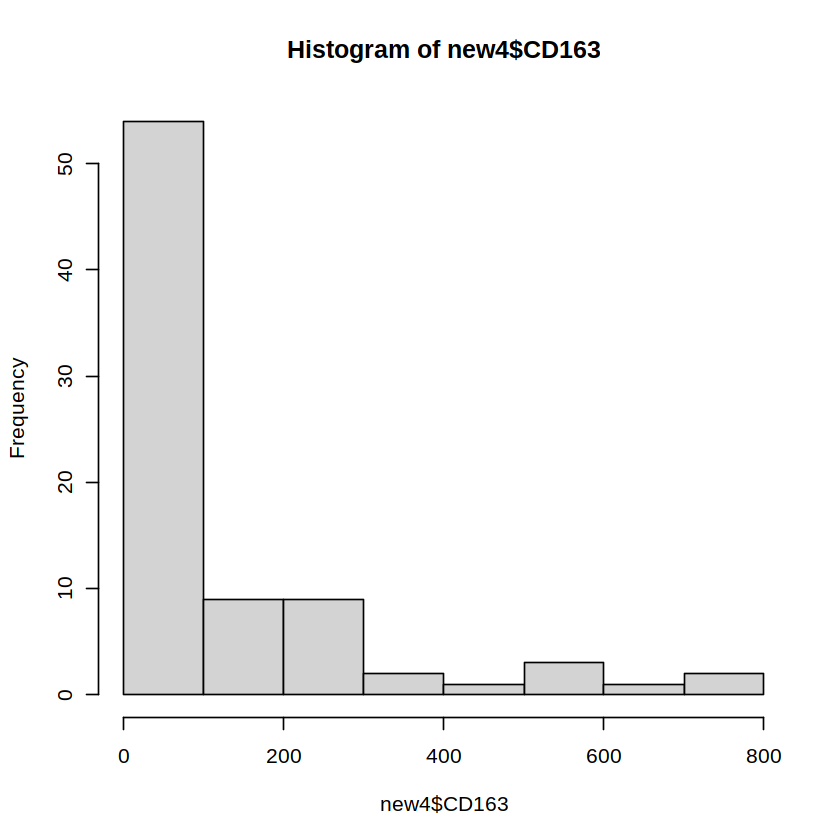

In [67]:
hist(new4$CD163)


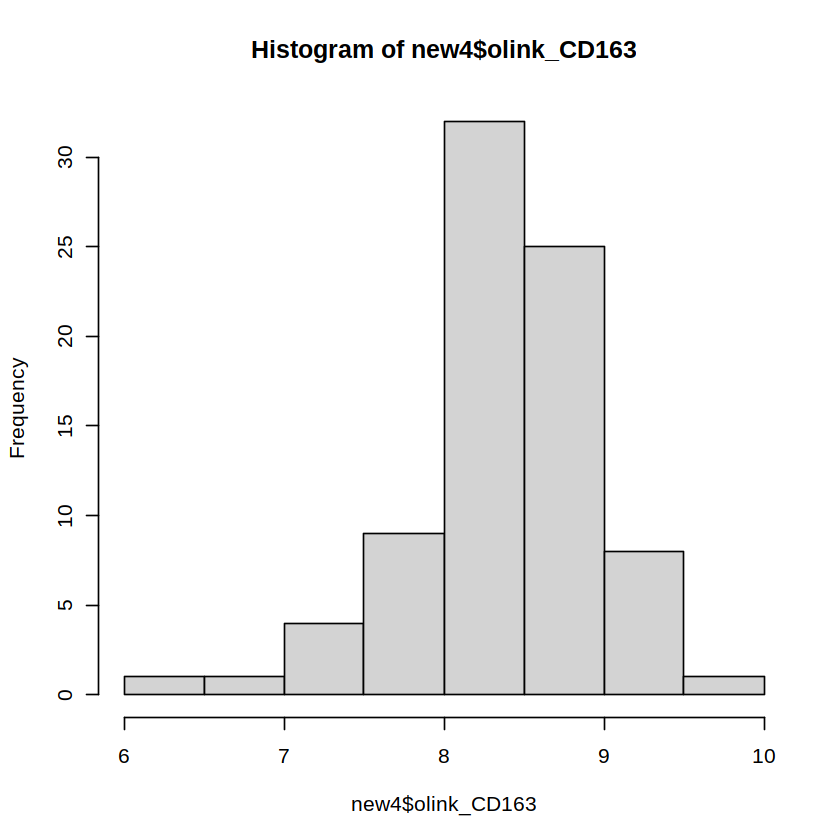

In [68]:
hist(new4$olink_CD163)


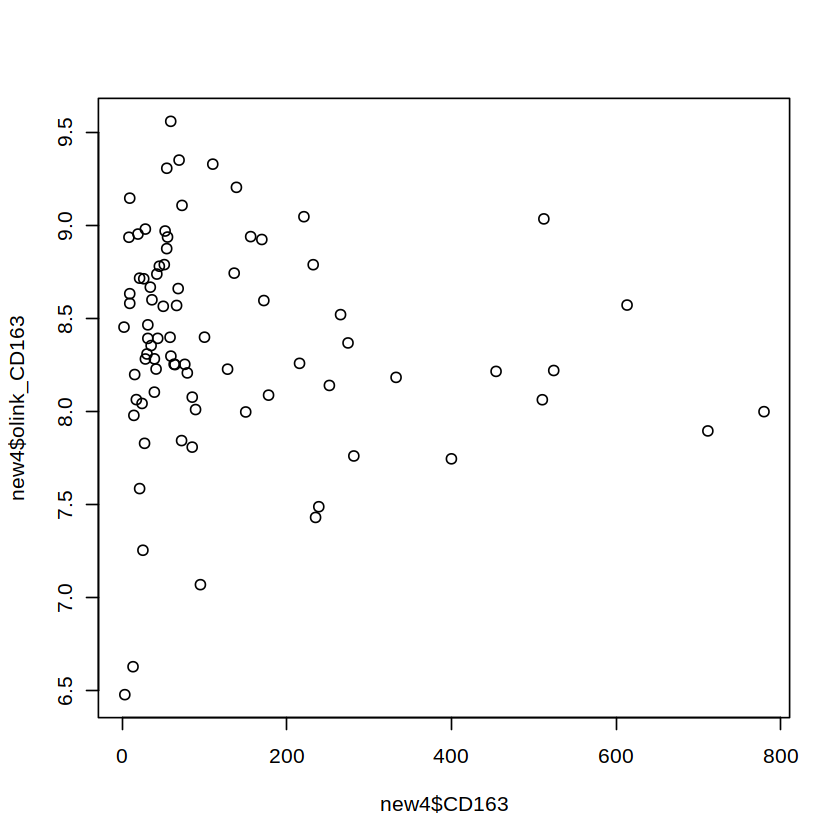

In [69]:
plot(new4$CD163,new4$olink_CD163)


In [71]:
library(scater)


Attaching package: ‘scater’


The following object is masked from ‘package:limma’:

    plotMDS




In [75]:
sce<-data

sce$individual_id<-factor(sce$individual_id)
sce$sample_id<-factor(sce$sample_id)
sce$ethnicity<-factor(sce$ethnicity)
sce$sex<-factor(sce$sex)
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age


In [79]:
#names(colData(data))

In [76]:
# want some violin/box plots

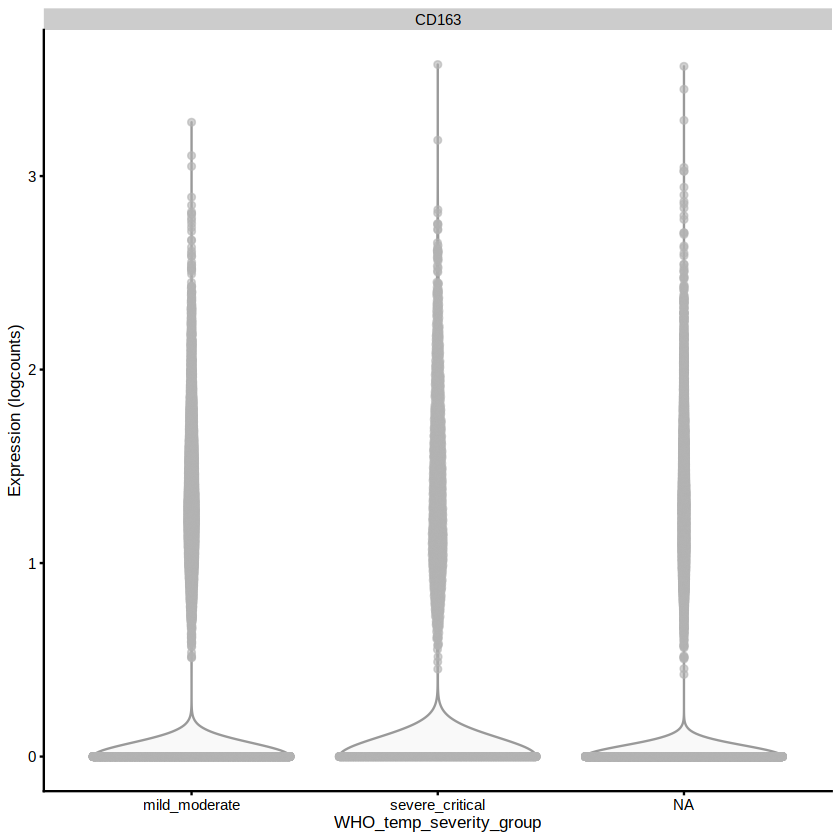

In [80]:
plotExpression(sce,"CD163",x="WHO_temp_severity_group")

In [202]:
long_df6<-reshape2::melt(new4)
rec<-"AB.CD40"
lig<-"TNFSF13B"


Using sample_id, individual_id as id variables



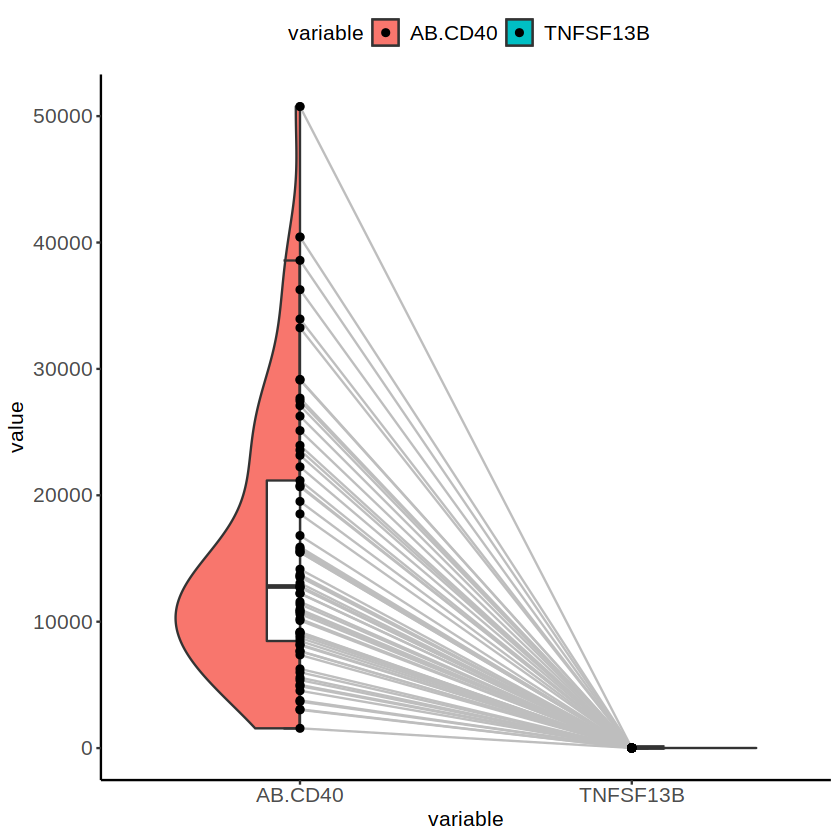

In [203]:
ggplot(data.frame(long_df6[long_df6$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df6) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df6) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df6) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df6) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")


In [204]:

cal_z_score <- function(x){
  (x - mean(x,na.rm=TRUE)) / sd(x,na.rm=TRUE)
}

new4[,2:574] <- apply(new4[,2:574], 2, cal_z_score)


In [205]:
long_df7<-reshape2::melt(new4)


Using sample_id, individual_id as id variables



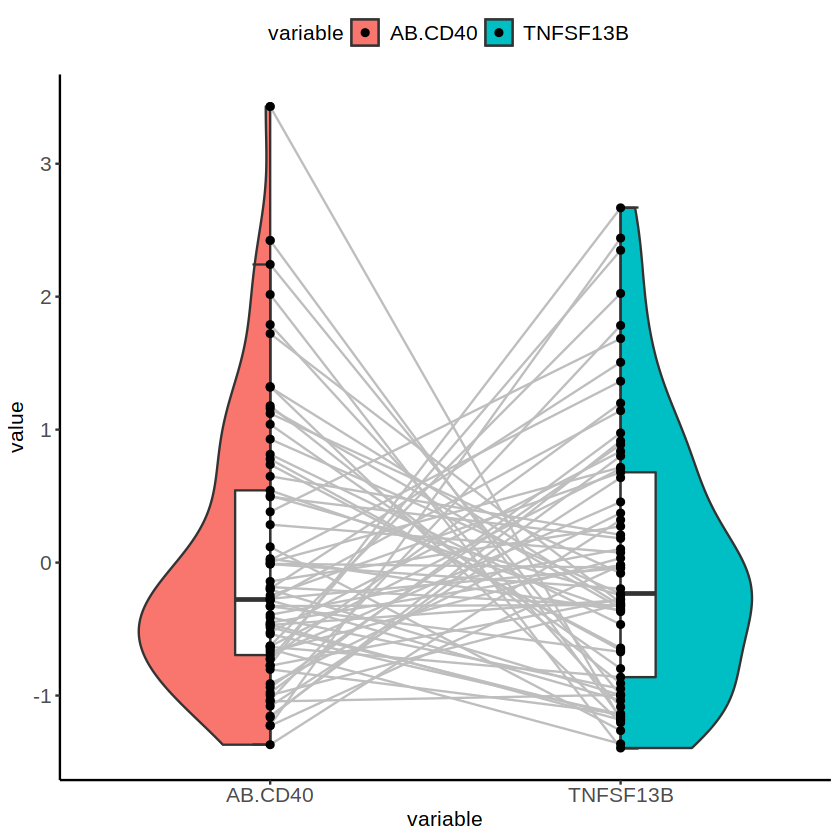

In [206]:

ggplot(data.frame(long_df7[long_df7$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df7) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df7) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df7) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df7) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")


In [207]:
y <- DGEList(counts = counts(smrzd2), samples = colData(smrzd2))


In [208]:
dgelist2<-y


In [209]:
dgelist2 <- calcNormFactors(dgelist2)


In [210]:
logcpm <- cpm(dgelist2, log=TRUE,normalized.lib.sizes=TRUE,prior.count=1)


In [211]:

cpm <- cpm(dgelist2, log=FALSE,normalized.lib.sizes=TRUE,prior.count=1)


In [212]:
tmp6<-data.frame(t(cpm))
tmp6$sample_id<-rownames(tmp6)


In [213]:
wide_olink<-dcast(olink,Original_SampleID~GeneID,value.var="NPX")
names(wide_olink)[1]<-"sample_id"


Warning message in dcast(olink, Original_SampleID ~ GeneID, value.var = "NPX"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(olink). In the next version, this warning will become an error.”


In [214]:
new5<-merge(tmp6,wide_olink,by="sample_id",all.x=TRUE)
head(new5)
dim(new5)


sample_id AB.ADGRG1 AB.ANPEP AB.B3GAT1 AB.BTLA   AB.C5AR1 AB.CCR4  AB.CCR5 
1 C103_2204 4771.977  1547.455 15964.597  7447.362 5758.959 1578.278 5235.224
2 C104_2204 4273.389  3926.542 18279.534  5897.131 9792.323 1306.185 5422.972
3 C106_2204 7591.264  2639.178 22015.372  5171.778 4584.517 1878.535 1476.956
4 C113_0605 2089.024  1635.189  5659.909 10828.412 4612.593 1225.678 1539.421
5 C113_2304 1608.887  1079.579  8002.113  7310.807 3466.895 1978.903 1980.500
6 C113_2904 1473.962  1855.691  3619.278  9984.100 3213.489 2102.505 3022.560
  AB.CCR6   AB.CD101  ⋯ TRIM21  TRIM5   TSLP     UMOD    VASN    VCAM1  
1 1167.5125 14665.134 ⋯ 2.42722 2.73218  1.73733 0.63036 2.10298 5.72934
2 1079.8171 21106.620 ⋯ 3.02218 2.64737 -0.22372 0.61822 2.46803 5.61442
3  802.1896 16345.354 ⋯ 2.39754 2.41437  0.81331 0.58710 2.46791 5.48022
4 1762.1396  4762.723 ⋯ 2.39262 2.88367  0.98505 0.47552 2.81779 6.11572
5 3081.9234  3207.126 ⋯ 3.19469 2.61469  1.22499 0.89623 2.66852 6.77634
6 1416.9702  7215.355 ⋯ 2.50348 2.33191  0.56714 0.85136 2.75854 6.67321
  VEGFA    VSIG2   VWF     ZBTB16 
1 13.16634 6.84396 7.64381 2.39522
2 13.13383 7.12135 5.09707 2.07063
3 13.19553 7.78474 7.25253 1.88304
4 12.99018 6.36287 6.49356 3.00130
5 13.14894 6.18068 6.40599 1.98728
6 13.22140 6.30056 6.88699 2.66870

[1]  69 574

In [215]:
new5$individual_id<-gsub("_[0-9]+","",new5$sample_id)


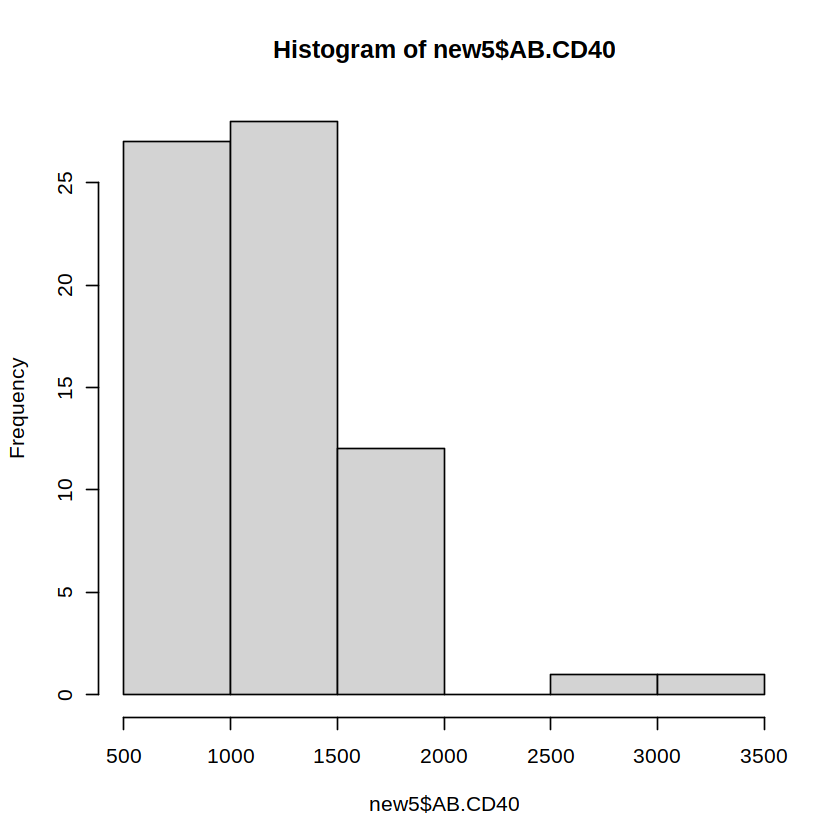

In [216]:
hist(new5$AB.CD40)


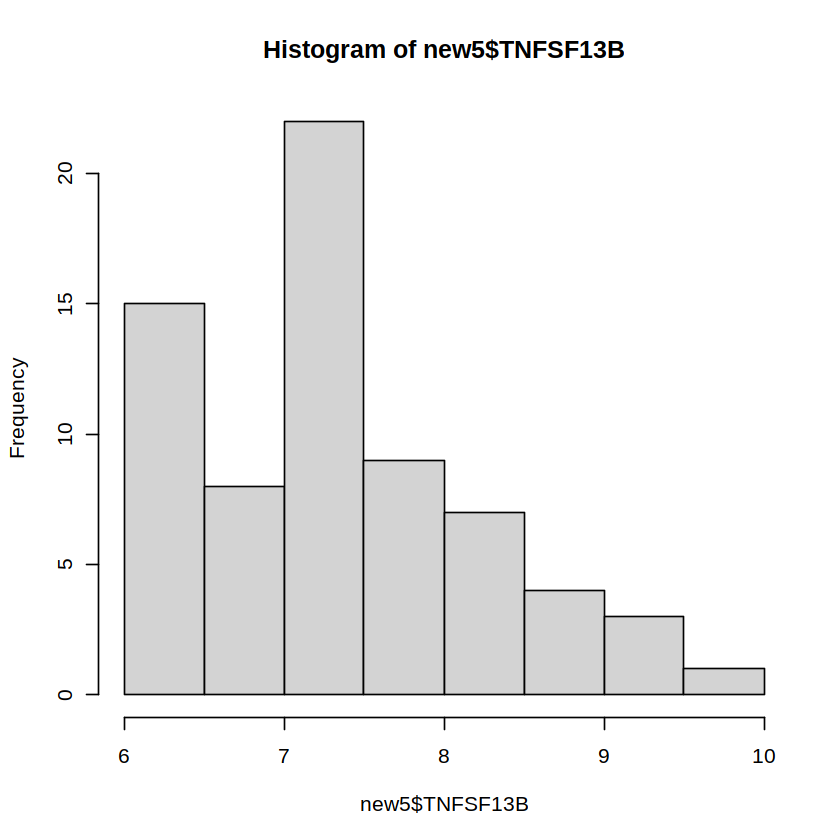

In [217]:
hist(new5$TNFSF13B)


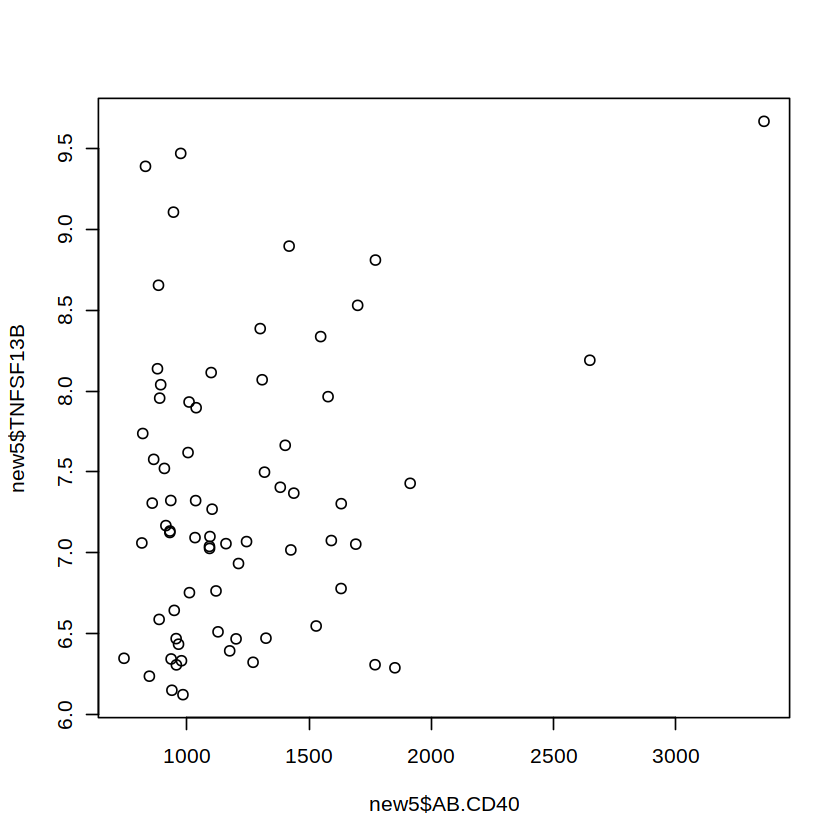

In [219]:
plot(new5$AB.CD40,new5$TNFSF13B)


In [220]:
long_df8<-reshape2::melt(new5)


Using sample_id, individual_id as id variables



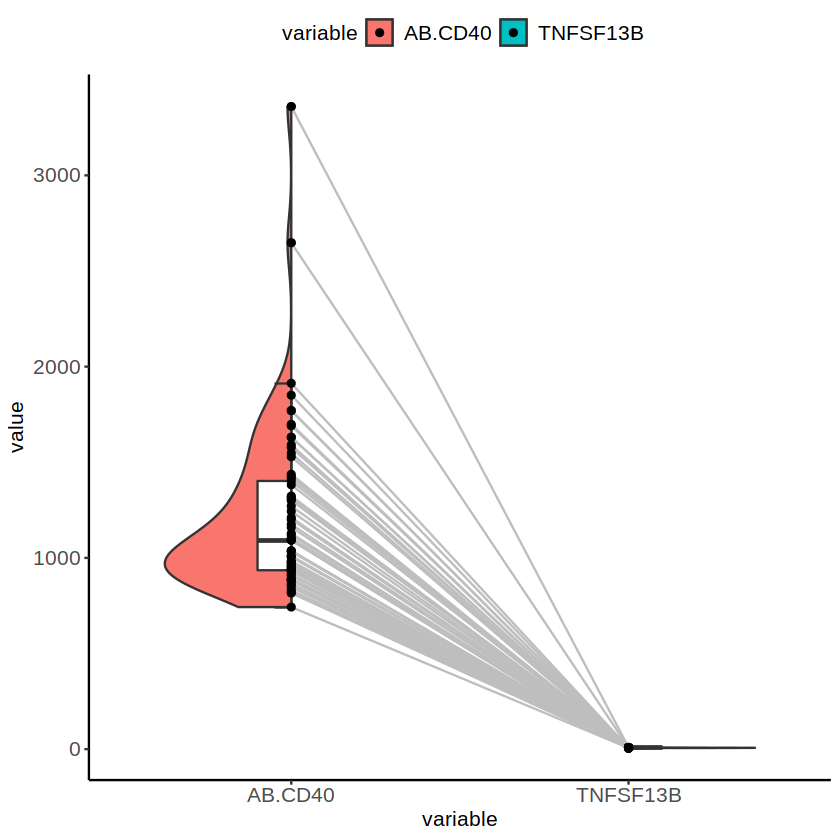

In [221]:
ggplot(data.frame(long_df8[long_df8$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df8) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df8) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df8) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df8) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")


In [222]:

cal_z_score <- function(x){
  (x - mean(x,na.rm=TRUE)) / sd(x,na.rm=TRUE)
}

new5[,2:574] <- apply(new5[,2:574], 2, cal_z_score)


In [223]:
long_df9<-reshape2::melt(new5)



Using sample_id, individual_id as id variables



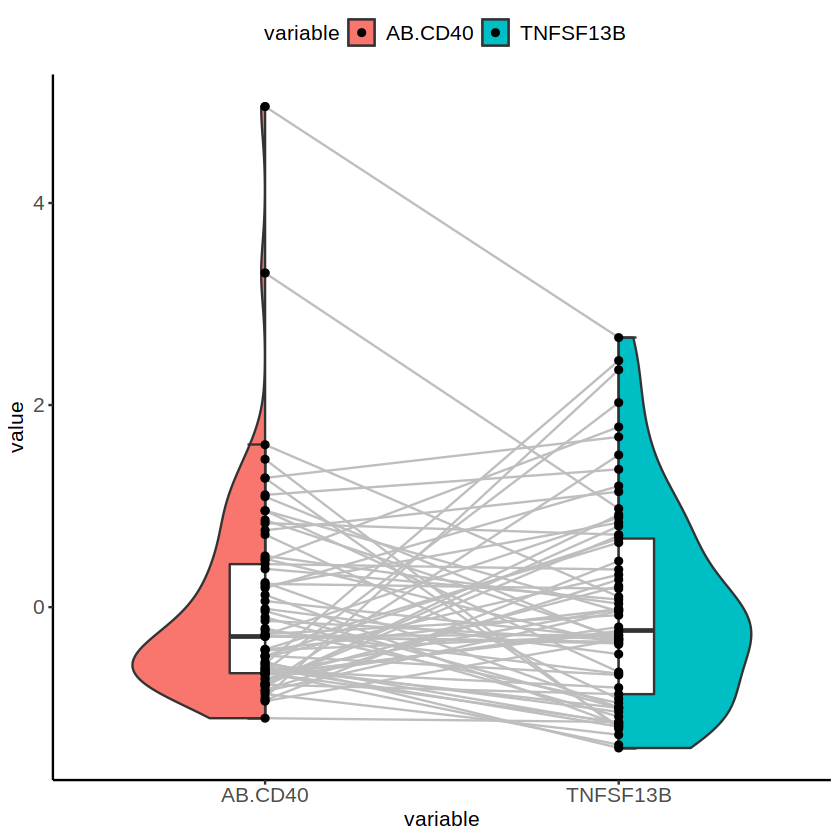

In [224]:
ggplot(data.frame(long_df9[long_df9$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df9) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df9) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df9) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df9) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")




In [225]:
tmp7<-data.frame(t(logcpm))
tmp7$sample_id<-rownames(tmp7)


In [226]:
wide_olink<-dcast(olink,Original_SampleID~GeneID,value.var="NPX")
names(wide_olink)[1]<-"sample_id"


Warning message in dcast(olink, Original_SampleID ~ GeneID, value.var = "NPX"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(olink). In the next version, this warning will become an error.”


In [227]:
new6<-merge(tmp7,wide_olink,by="sample_id",all.x=TRUE)
head(new6)
dim(new6)


sample_id AB.ADGRG1 AB.ANPEP AB.B3GAT1 AB.BTLA  AB.C5AR1 AB.CCR4  AB.CCR5 
1 C103_2204 12.22039  10.59575 13.96260  12.86253 12.49161 10.62420 12.35406
2 C104_2204 12.06119  11.93907 14.15795  12.52582 13.25745 10.35123 12.40489
3 C106_2204 12.89014  11.36591 14.42623  12.33647 12.16258 10.87545 10.52848
4 C113_0605 11.02866  10.67531 12.46658  13.40254 12.17139 10.25945 10.58824
5 C113_2304 10.65191  10.07635 12.96618  12.83583 11.75946 10.95054 10.95170
6 C113_2904 10.52556  10.85780 11.82152  13.28543 11.64996 11.03794 11.56159
  AB.CCR6   AB.CD101 ⋯ TRIM21  TRIM5   TSLP     UMOD    VASN    VCAM1  
1 10.189314 13.84011 ⋯ 2.42722 2.73218  1.73733 0.63036 2.10298 5.72934
2 10.076671 14.36541 ⋯ 3.02218 2.64737 -0.22372 0.61822 2.46803 5.61442
3  9.647933 13.99660 ⋯ 2.39754 2.41437  0.81331 0.58710 2.46791 5.48022
4 10.783173 12.21759 ⋯ 2.39262 2.88367  0.98505 0.47552 2.81779 6.11572
5 11.589650 11.64710 ⋯ 3.19469 2.61469  1.22499 0.89623 2.66852 6.77634
6 10.468669 12.81687 ⋯ 2.50348 2.33191  0.56714 0.85136 2.75854 6.67321
  VEGFA    VSIG2   VWF     ZBTB16 
1 13.16634 6.84396 7.64381 2.39522
2 13.13383 7.12135 5.09707 2.07063
3 13.19553 7.78474 7.25253 1.88304
4 12.99018 6.36287 6.49356 3.00130
5 13.14894 6.18068 6.40599 1.98728
6 13.22140 6.30056 6.88699 2.66870

[1]  69 574

In [228]:
new6$individual_id<-gsub("_[0-9]+","",new6$sample_id)


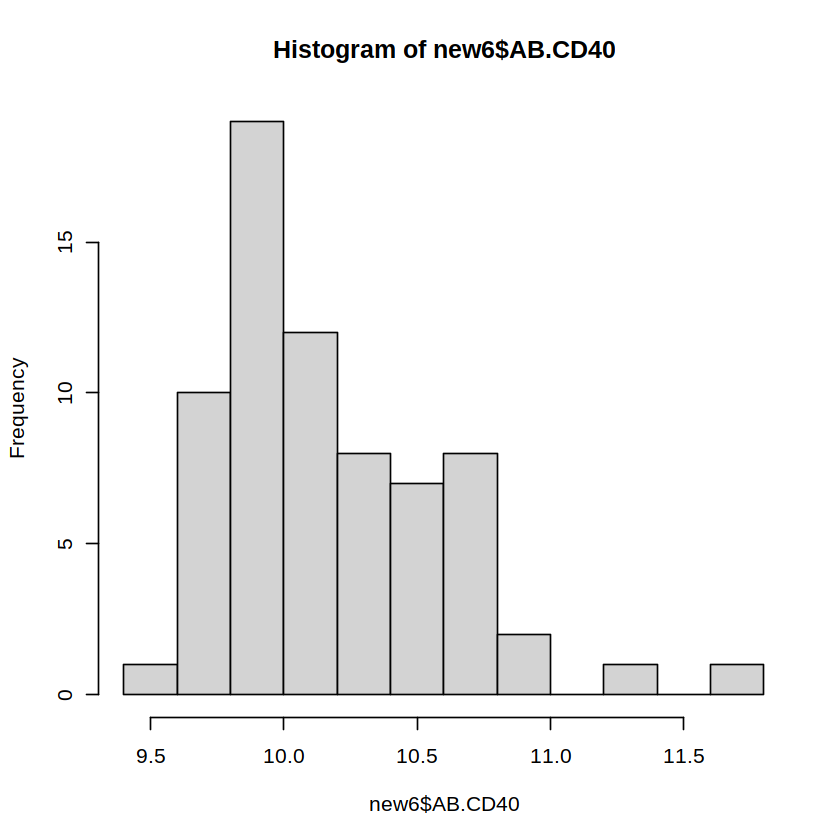

In [229]:
hist(new6$AB.CD40)


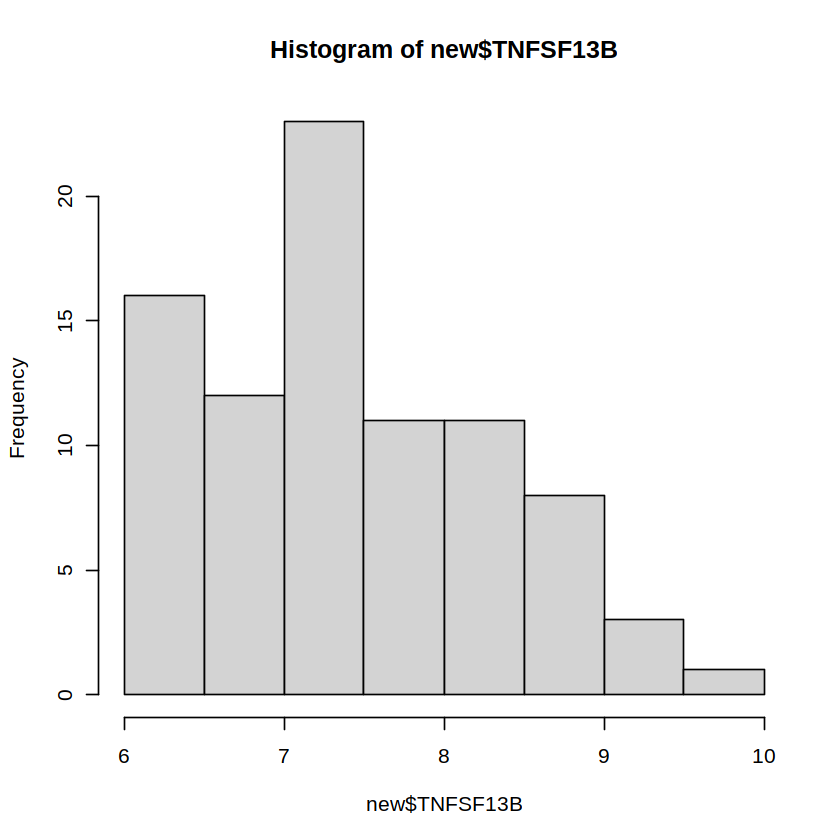

In [230]:
hist(new$TNFSF13B)


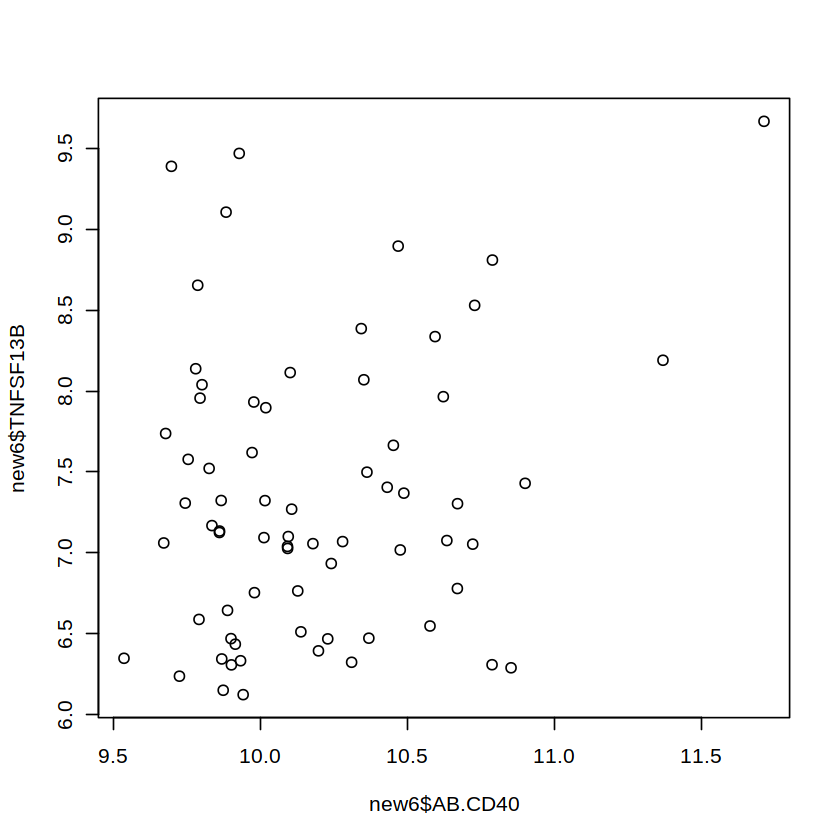

In [233]:
plot(new6$AB.CD40,new6$TNFSF13B)


In [232]:
long_df10<-reshape2::melt(new6)


Using sample_id, individual_id as id variables



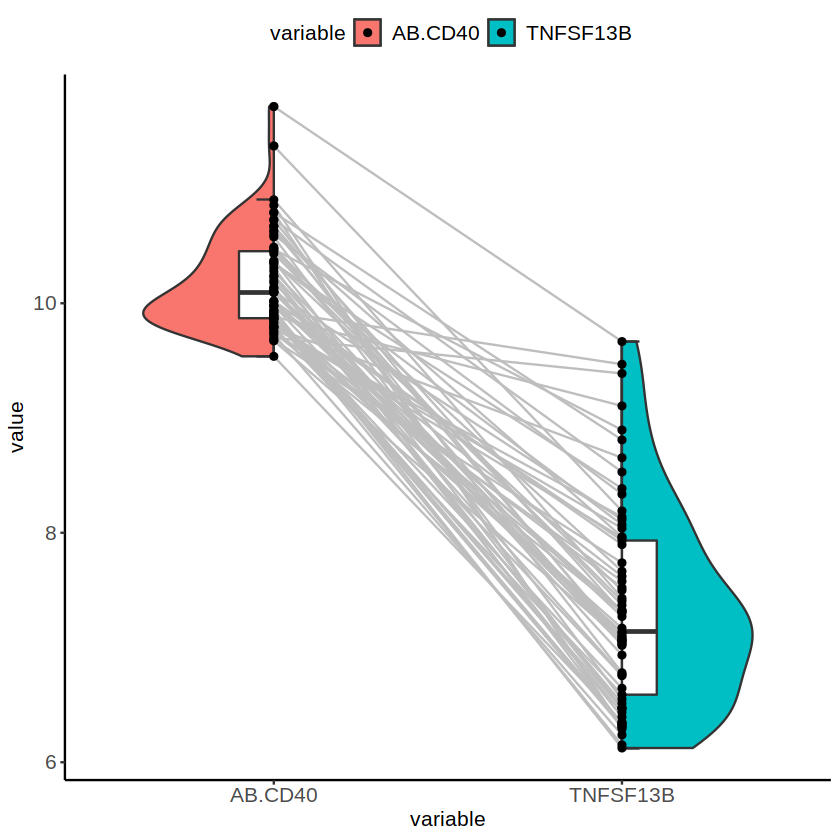

In [234]:

ggplot(data.frame(long_df10[long_df10$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df10) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df10) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df10) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df10) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")



In [235]:

cal_z_score <- function(x){
  (x - mean(x,na.rm=TRUE)) / sd(x,na.rm=TRUE)
}

new6[,2:574] <- apply(new6[,2:574], 2, cal_z_score)


In [236]:
long_df11<-reshape2::melt(new6)


Using sample_id, individual_id as id variables



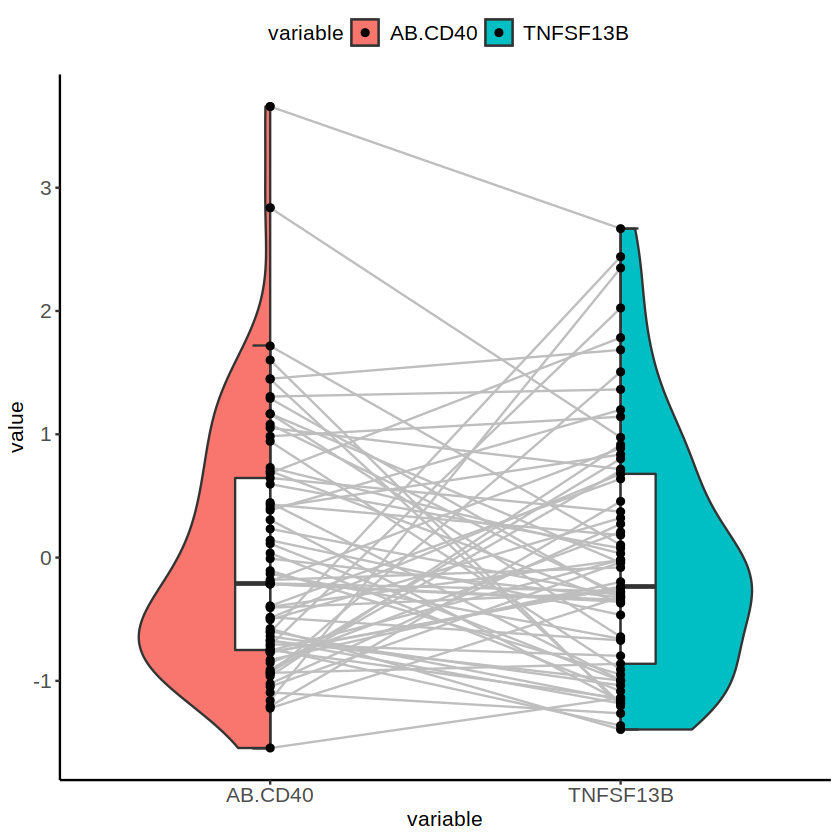

In [237]:

ggplot(data.frame(long_df11[long_df11$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df11) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df11) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df11) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df11) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")




In [126]:
dim(data.frame(counts(smrzd)))

[1] 137  85

In [127]:
dim(data.frame(counts(smrzd))[rowSums(data.frame(counts(smrzd)) == 0)<1, ])

[1] 23 85

In [124]:
sum(data.frame(counts(smrzd))[rowSums(data.frame(counts(smrzd)) == 0), ]==0)

[1] 805

In [104]:
head(data.frame(counts(smrzd)))

C103_2204 C104_2204 C106_2204 C134_2904 C142_3004 C152_0405 C161_1105
AB-ADGRG1  67779.57 135974.82 185981.64 22343.414 117069.4     0.000     0.000 
AB-ANPEP   21979.54 124938.49  64658.35  7550.839 106401.4     0.000     0.000 
AB-B3GAT1 226755.80 581635.83 539364.08 62214.513 509518.1  3903.925  1313.002 
AB-BTLA   105779.83 187640.60 126705.62 24129.597 164478.4     0.000     0.000 
AB-C5AR1   81798.33 311581.56 112318.06 20514.566 130420.4     0.000     0.000 
AB-CCR4    22417.33  41561.46  46023.04 14010.482  79701.1     0.000     0.000 
          C164_1105    C167_1205    C193_2605 ⋯ C214_2705 C224_2805 C234_2805 
AB-ADGRG1    0.0000000 1.193567e+00  91624.14 ⋯  32787.03  73275.51  43703.415
AB-ANPEP     0.0000000 1.382873e+00  85091.62 ⋯  57084.13  56819.03  14457.282
AB-B3GAT1 4302.6277855 1.328685e+04 412076.73 ⋯ 104342.36 340516.08 116514.326
AB-BTLA      0.0000000 2.226002e-01 164187.05 ⋯ 140382.65  60445.43  88191.053
AB-C5AR1     0.0000000 1.450563e-01 236977.24 ⋯ 136908.15  49745.60  33271.465
AB-CCR4      0.4391751 4.102455e+00  74062.64 ⋯  20552.12  26739.38   8204.565
          C237_2805 C238_2905 C240_2905 C246_2905 C251_2905 C69_1804  C85_2004 
AB-ADGRG1  54668.16  56838.64  59420     26950     39555     80779.93 14008.300
AB-ANPEP   22626.80  25481.71  44745     15854     30902     13571.69  8684.635
AB-B3GAT1 392327.34 240844.46 333885    148868    122644    225808.73 33222.241
AB-BTLA    36545.64 103775.83 146436     64674    143980    107137.64 26882.981
AB-C5AR1   27587.90  50832.08 117788     48646     94581     22533.55 10202.499
AB-CCR4    12991.45  32179.83  44651     17410     27303     33798.98  9208.651

In [105]:
sum(data.frame(counts(smrzd))==0)

[1] 344

In [ ]:
## want to trim further
#remove samples with median counts across markers <1
#C152_0405
#C161_1105
#C164_1105
#C167_1205

In [172]:
#summary(data.frame(counts(smrzd)))

In [173]:
#summary(data.frame(t(counts(smrzd))))

In [31]:
#########
# New Normalisation step edgeR
#########

In [31]:
y <- DGEList(counts = counts(smrzd), samples = colData(smrzd))

In [32]:
dgelist<-y

In [33]:
dgelist <- calcNormFactors(dgelist)

In [34]:
head(dgelist$samples)

group lib.size norm.factors orig.ident nCount_RNA nFeature_RNA
C103_2204 1     14621997 2.813314     NA         NA         NA          
C104_2204 1     39724901 2.850639     NA         NA         NA          
C106_2204 1     30774313 2.351667     NA         NA         NA          
C113_0605 1      2099189 3.238382     NA         NA         NA          
C113_2304 1      3812562 1.889096     NA         NA         NA          
C113_2904 1     12071087 2.866114     NA         NA         NA          
          nCount_ADT nFeature_ADT nCount_ADT_raw nFeature_ADT_raw ⋯ VASN   
C103_2204 NA         NA           NA             NA               ⋯ 2.10298
C104_2204 NA         NA           NA             NA               ⋯ 2.46803
C106_2204 NA         NA           NA             NA               ⋯ 2.46791
C113_0605 NA         NA           NA             NA               ⋯ 2.81779
C113_2304 NA         NA           NA             NA               ⋯ 2.66852
C113_2904 NA         NA           NA             NA               ⋯ 2.75854
          VCAM1   VEGFA    VSIG2   VWF     ZBTB16  ident individual_id
C103_2204 5.72934 13.16634 6.84396 7.64381 2.39522 NA    C103         
C104_2204 5.61442 13.13383 7.12135 5.09707 2.07063 NA    C104         
C106_2204 5.48022 13.19553 7.78474 7.25253 1.88304 NA    C106         
C113_0605 6.11572 12.99018 6.36287 6.49356 3.00130 NA    C113         
C113_2304 6.77634 13.14894 6.18068 6.40599 1.98728 NA    C113         
C113_2904 6.67321 13.22140 6.30056 6.88699 2.66870 NA    C113         
          ids       ncells
C103_2204 C103_2204  8745 
C104_2204 C104_2204 11384 
C106_2204 C106_2204  9231 
C113_0605 C113_0605  3278 
C113_2304 C113_2304  2165 
C113_2904 C113_2904  5429

In [35]:
logcpm <- cpm(dgelist, log=TRUE,normalized.lib.sizes=TRUE,prior.count=1)

In [36]:
cpm <- cpm(dgelist, log=FALSE,normalized.lib.sizes=TRUE,prior.count=1)

In [37]:
tmp1<-data.frame(t(counts(smrzd)))

In [38]:
#hist(tmp1$AB.CD40)

In [39]:
#plot(tmp1$AB.CD40,tmp1$TNFSF13B)

In [40]:
#tmp<-data.frame(t(logcpm))

In [41]:
#head(tmp)
#dim(tmp)

In [42]:
tmp1$sample_id<-rownames(tmp1)

In [43]:
wide_olink<-dcast(olink,Original_SampleID~GeneID,value.var="NPX")

Warning message in dcast(olink, Original_SampleID ~ GeneID, value.var = "NPX"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(olink). In the next version, this warning will become an error.”


In [44]:
names(wide_olink)[1]<-"sample_id"

In [45]:
new<-merge(tmp1,wide_olink,by="sample_id",all.x=TRUE)

In [46]:
head(new)
dim(new)

sample_id AB.ADGRG1  AB.ANPEP   AB.B3GAT1 AB.BTLA   AB.C5AR1   AB.CCR4  
1 C103_2204  67779.567  21979.536 226755.80 105779.83  81798.332 22417.332
2 C104_2204 135974.821 124938.493 581635.83 187640.60 311581.562 41561.464
3 C106_2204 185981.641  64658.348 539364.08 126705.62 112318.058 46023.035
4 C113_0605   4399.285   3443.553  11919.23  22803.60   9713.681  2581.161
5 C113_2304   3677.859   2467.881  18292.55  16712.25   7925.200  4523.702
6 C113_2904  16241.533  20447.789  39880.70 110014.45  35409.318 23167.429
  AB.CCR5    AB.CCR6   AB.CD101   ⋯ TRIM21  TRIM5   TSLP     UMOD    VASN   
1  74359.373 16582.957 208298.655 ⋯ 2.42722 2.73218  1.73733 0.63036 2.10298
2 172553.338 34358.659 671590.771 ⋯ 3.02218 2.64737 -0.22372 0.61822 2.46803
3  36184.591 19653.188 400451.849 ⋯ 2.39754 2.41437  0.81331 0.58710 2.46791
4   3241.874  3710.898  10029.841 ⋯ 2.39262 2.88367  0.98505 0.47552 2.81779
5   4527.354  7045.169   7331.378 ⋯ 3.19469 2.61469  1.22499 0.89623 2.66852
6  33305.479 15613.544  79505.740 ⋯ 2.50348 2.33191  0.56714 0.85136 2.75854
  VCAM1   VEGFA    VSIG2   VWF     ZBTB16 
1 5.72934 13.16634 6.84396 7.64381 2.39522
2 5.61442 13.13383 7.12135 5.09707 2.07063
3 5.48022 13.19553 7.78474 7.25253 1.88304
4 6.11572 12.99018 6.36287 6.49356 3.00130
5 6.77634 13.14894 6.18068 6.40599 1.98728
6 6.67321 13.22140 6.30056 6.88699 2.66870

[1]  85 574

In [47]:
new$individual_id<-gsub("_[0-9]+","",new$sample_id)

In [48]:
#df<-apply(pairs,1,function(x){
   # #print(x[1])
    ##print(x[2])
    #res<-rmcorr(individual_id,paste0("AB.",x[1]),x[2],new)
    #out<-data.frame(cite=paste0("AB.",x[1]),olink=x[2],r=res$r,p=res$p,ciupper=res$CI[2],cilower=res$CI[1])
    #return(out)
#})


In [49]:
#df<-do.call(rbind,df)
#head(df)
#dim(df)

In [50]:
#df$label<-paste0(gsub("AB.","",(df$cite)),"-",df$olink)

In [51]:
#head(df)

In [52]:
#df$protein<-"protein"

In [53]:
#order_want<-df[order(df$r),"label"]

In [54]:
#df$label<-factor(df$label,levels=order_want)

In [55]:
#ggplot(df,aes(x=protein,y=label,fill=r))+
    #geom_tile()+
    #scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
  # midpoint = 0) +
    #theme_classic()
#ggsave("cite_olink_receptor_ligand_correlation_heatmap.pdf",width=5)

In [56]:
#getwd()

In [57]:
#df$padj<-p.adjust(df$p, method = "BH", n = length(df$p))

In [58]:
#head(df)

In [59]:
#write.table(df,"receptor_ligand_res.tsv",col.names=TRUE,row.names=FALSE,quote=FALSE,sep="\t")


In [60]:
#head(new)

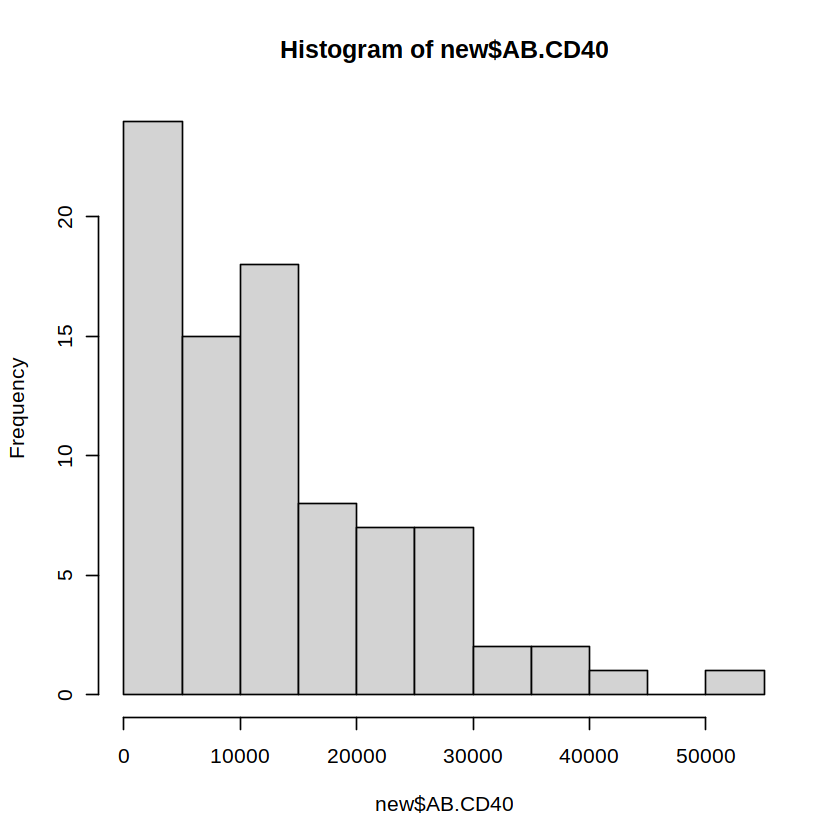

In [61]:
hist(new$AB.CD40)

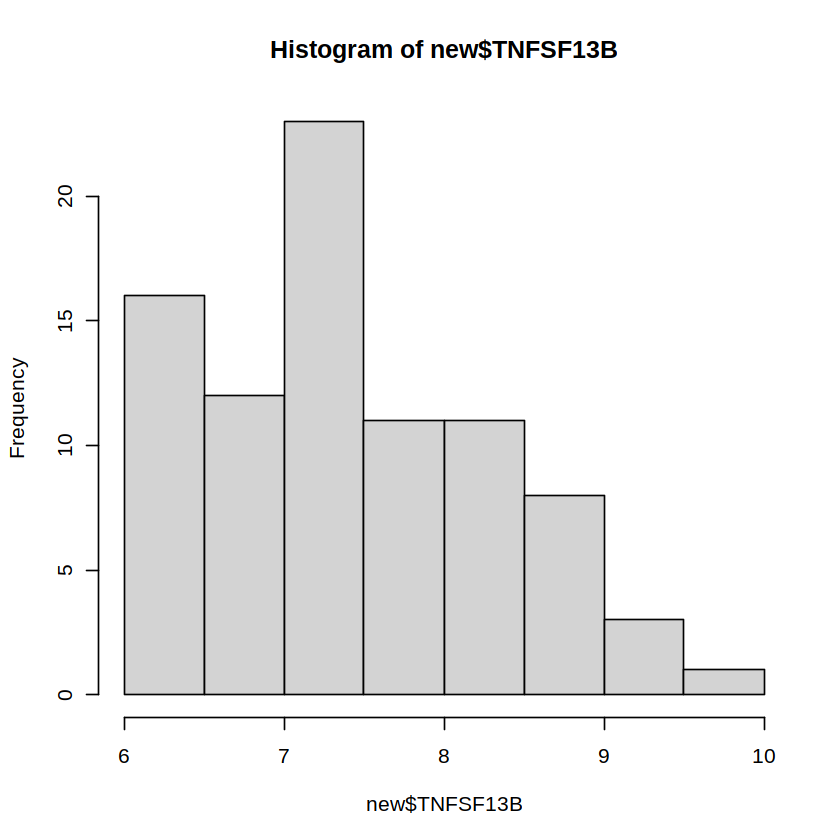

In [62]:
hist(new$TNFSF13B)

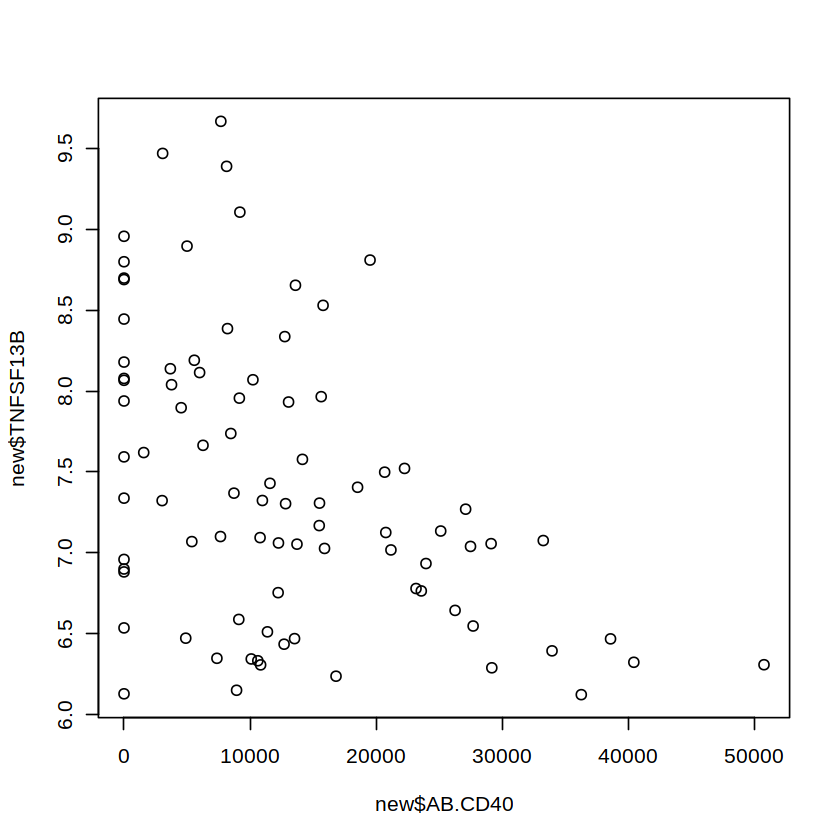

In [68]:
plot(new$AB.CD40,new$TNFSF13B)

In [30]:
long_df1<-reshape2::melt(new)

Using sample_id, individual_id as id variables



In [31]:
rec<-"AB.CD40"
lig<-"TNFSF13B"

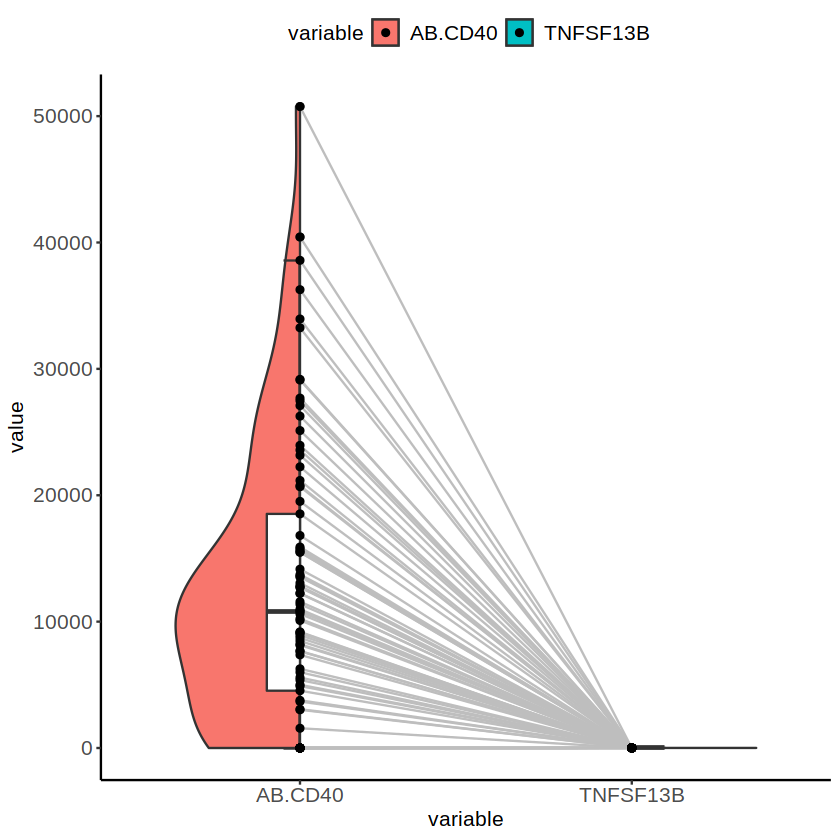

In [32]:
ggplot(data.frame(long_df1[long_df1$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df1) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df1) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df1) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df1) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")
    

In [33]:
cal_z_score <- function(x){
  (x - mean(x,na.rm=TRUE)) / sd(x,na.rm=TRUE)
}

new[,2:574] <- apply(new[,2:574], 2, cal_z_score)


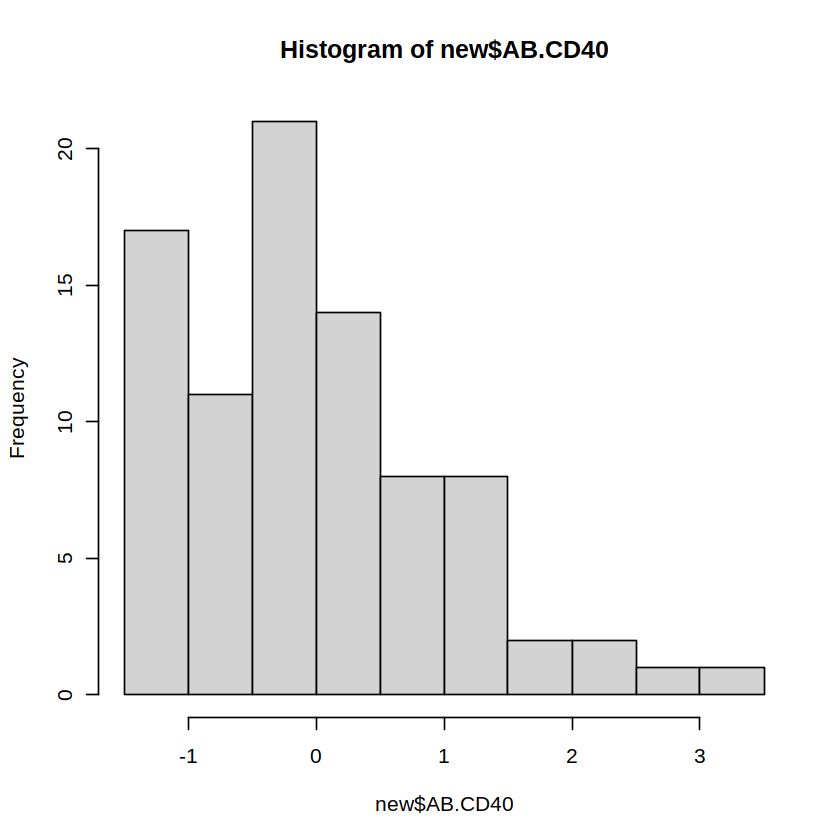

In [34]:
hist(new$AB.CD40)

In [35]:
long_df2<-reshape2::melt(new)

Using sample_id, individual_id as id variables



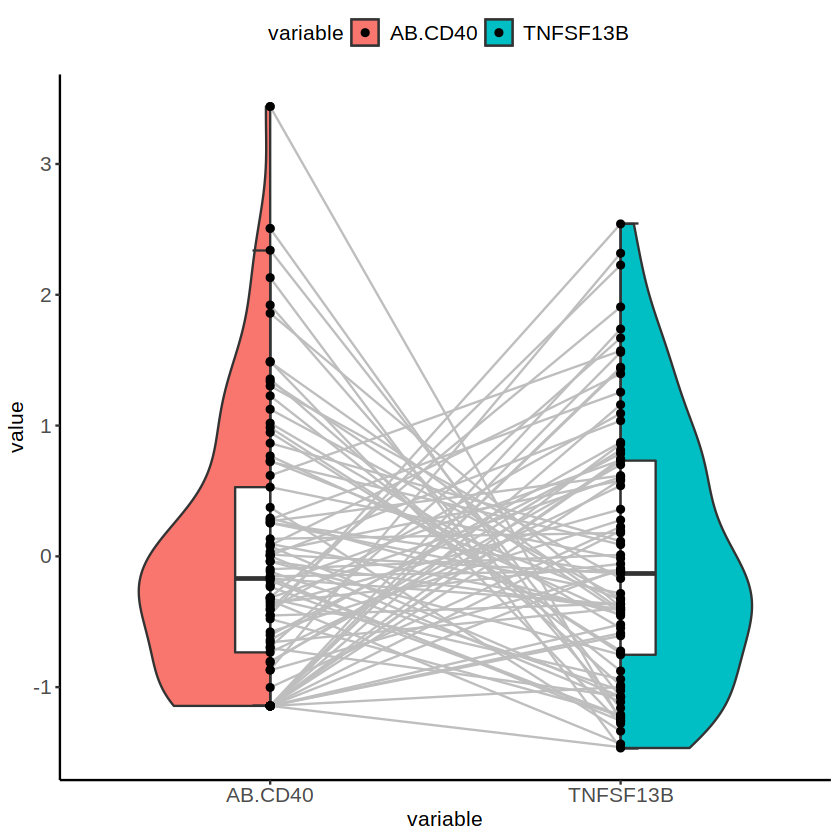

In [36]:
ggplot(data.frame(long_df2[long_df2$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df2) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df2) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df2) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df2) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")
    

In [ ]:
# seurat log counts summarised

In [7]:
data

class: SingleCellExperiment 
dim: 137 371084 
metadata(0):
assays(3): counts logcounts scaledata
rownames(137): AB-ADGRG1 AB-ANPEP ... AB-TCRVd2 AB-IgL
rowData names(0):
colnames(371084): UK-CIC10689738+UK-CIC10690026_AAACCTGAGGCAATTA-1
  UK-CIC10689738+UK-CIC10690026_AAACCTGCAAGCCGCT-1 ...
  UK-CIC10689787+UK-CIC10690075_TTTGTCAGTTGTGGCC-1
  UK-CIC10689787+UK-CIC10690075_TTTGTCATCAAACAAG-1
colData names(603): orig.ident nCount_RNA ... ZBTB16 ident
reducedDimNames(1): APCA
mainExpName: ADT
altExpNames(1): RNA

In [8]:
smrzd 

class: SingleCellExperiment 
dim: 137 85 
metadata(0):
assays(1): counts
rownames(137): AB-ADGRG1 AB-ANPEP ... AB-TCRVd2 AB-IgL
rowData names(0):
colnames(85): C103_2204 C104_2204 ... C93_2104 C93_2704
colData names(605): orig.ident nCount_RNA ... ids ncells
reducedDimNames(1): APCA
mainExpName: ADT
altExpNames(1): RNA

In [ ]:
smrzd2 <- aggregateAcrossCells(data, id=as.character(colData(data)[,c("sample_id")]),use.assay.type=c("counts","logcounts","scaledata"))


In [ ]:
smrzd2

In [ ]:
print("hello")

In [ ]:
################
#
################

In [37]:
head(logcpm)

C103_2204 C104_2204 C106_2204 C113_0605 C113_2304 C113_2904 C123_0505
AB-ADGRG1 10.686275 10.229794 11.327495  9.338079  8.996360  8.875001 10.889527
AB-ANPEP   9.061693 10.107678  9.803305  8.984744  8.420848  9.207221 11.468712
AB-B3GAT1 12.428456 12.326516 12.863573 10.775946 11.310545 10.170897 12.863207
AB-BTLA   11.328399 10.694407 10.773831 11.711894 11.180198 11.634780 11.487620
AB-C5AR1  10.957487 11.426024 10.599946 10.480756 10.103852  9.999345 11.014650
AB-CCR4    9.090144  8.519933  9.312863  8.568923  9.294967  9.387357  9.319408
          C123_2404 C123_2904 C124_0105 ⋯ C65_2504  C69_1804  C73_2004 
AB-ADGRG1 11.411803 11.949501 11.121022 ⋯  9.866602 11.096432  9.624176
AB-ANPEP   8.566875  9.787584  7.873008 ⋯  8.891191  8.523228  8.691588
AB-B3GAT1 13.172587 13.125115 12.900629 ⋯ 11.450916 12.579440 12.079073
AB-BTLA   10.960627 10.670564 10.975606 ⋯ 11.223638 11.503819 11.008460
AB-C5AR1   9.971725 10.954358  9.939879 ⋯ 10.560648  9.254610 10.512049
AB-CCR4    9.264589  8.665678 10.239418 ⋯  9.121142  9.839469  9.134908
          C73_2404  C82_2004  C82_2504  C85_2004  C93_0405  C93_2104  C93_2704
AB-ADGRG1  9.722258  9.634083 10.746753 10.160528 10.779420 10.718488 11.07754
AB-ANPEP   8.653300  8.982916  8.642568  9.470829  9.503052  9.313021  9.77188
AB-B3GAT1 11.159012 11.169275 11.751426 11.406352 12.521305 12.481287 13.12398
AB-BTLA   11.043987 11.074521 11.271483 11.100903 10.624775 11.309672 10.20768
AB-C5AR1  10.479343 10.580912  9.130837  9.703196 10.422447  9.960736 10.95995
AB-CCR4    8.370630  8.603685  8.861085  9.555346  9.663609  8.480652  9.30983

In [38]:
tmp2<-data.frame(t(logcpm))

tmp2$sample_id<-rownames(tmp2)


In [39]:
wide_olink<-dcast(olink,Original_SampleID~GeneID,value.var="NPX")
names(wide_olink)[1]<-"sample_id"
new2<-merge(tmp2,wide_olink,by="sample_id",all.x=TRUE)
head(new2)
dim(new2)


Warning message in dcast(olink, Original_SampleID ~ GeneID, value.var = "NPX"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(olink). In the next version, this warning will become an error.”


sample_id AB.ADGRG1 AB.ANPEP  AB.B3GAT1 AB.BTLA  AB.C5AR1  AB.CCR4  AB.CCR5  
1 C103_2204 10.686275  9.061693 12.42846  11.32840 10.957487 9.090144 10.819935
2 C104_2204 10.229794 10.107678 12.32652  10.69441 11.426024 8.519933 10.573482
3 C106_2204 11.327495  9.803305 12.86357  10.77383 10.599946 9.312863  8.965919
4 C113_0605  9.338079  8.984744 10.77595  11.71189 10.480756 8.568923  8.897685
5 C113_2304  8.996360  8.420848 11.31055  11.18020 10.103852 9.294967  9.296131
6 C113_2904  8.875001  9.207221 10.17090  11.63478  9.999345 9.387357  9.910980
  AB.CCR6  AB.CD101  ⋯ TRIM21  TRIM5   TSLP     UMOD    VASN    VCAM1  
1 8.655286 12.305972 ⋯ 2.42722 2.73218  1.73733 0.63036 2.10298 5.72934
2 8.245409 12.533980 ⋯ 3.02218 2.64737 -0.22372 0.61822 2.46803 5.61442
3 8.085450 12.433946 ⋯ 2.39754 2.41437  0.81331 0.58710 2.46791 5.48022
4 9.092603 10.526963 ⋯ 2.39262 2.88367  0.98505 0.47552 2.81779 6.11572
5 9.934049  9.991496 ⋯ 3.19469 2.61469  1.22499 0.89623 2.66852 6.77634
6 8.818119 11.166229 ⋯ 2.50348 2.33191  0.56714 0.85136 2.75854 6.67321
  VEGFA    VSIG2   VWF     ZBTB16 
1 13.16634 6.84396 7.64381 2.39522
2 13.13383 7.12135 5.09707 2.07063
3 13.19553 7.78474 7.25253 1.88304
4 12.99018 6.36287 6.49356 3.00130
5 13.14894 6.18068 6.40599 1.98728
6 13.22140 6.30056 6.88699 2.66870

[1]  85 574

In [40]:
new2$individual_id<-gsub("_[0-9]+","",new2$sample_id)

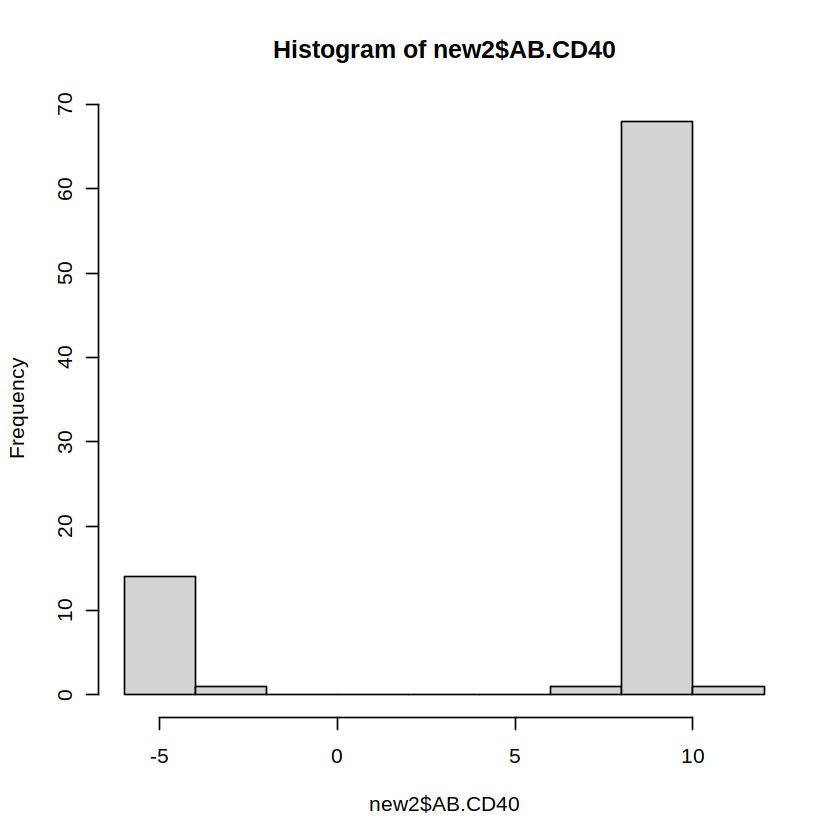

In [41]:
hist(new2$AB.CD40)

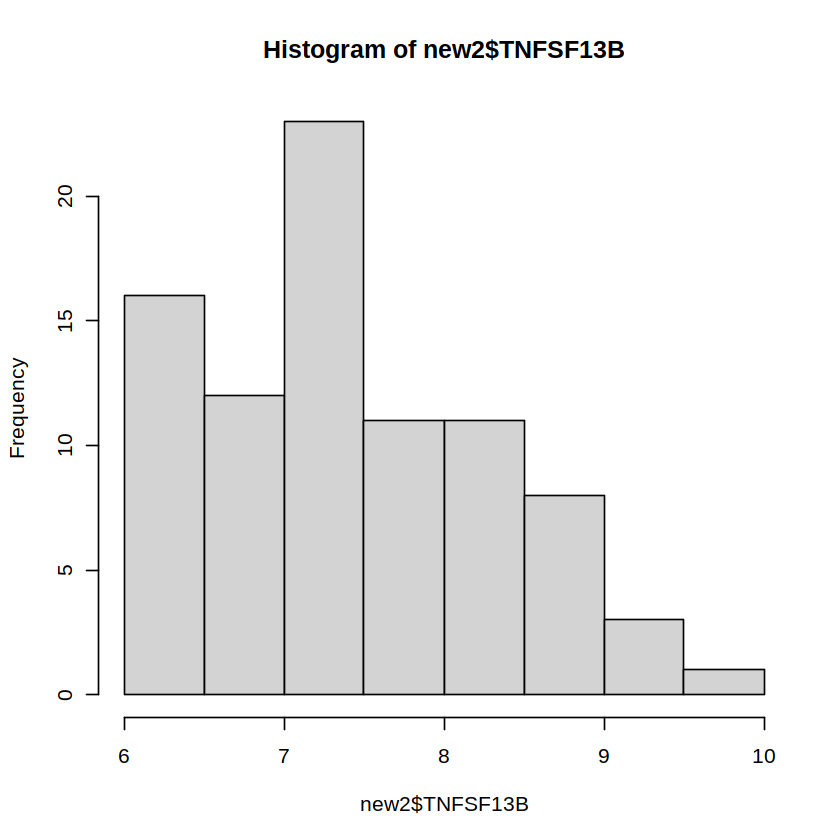

In [42]:
hist(new2$TNFSF13B)

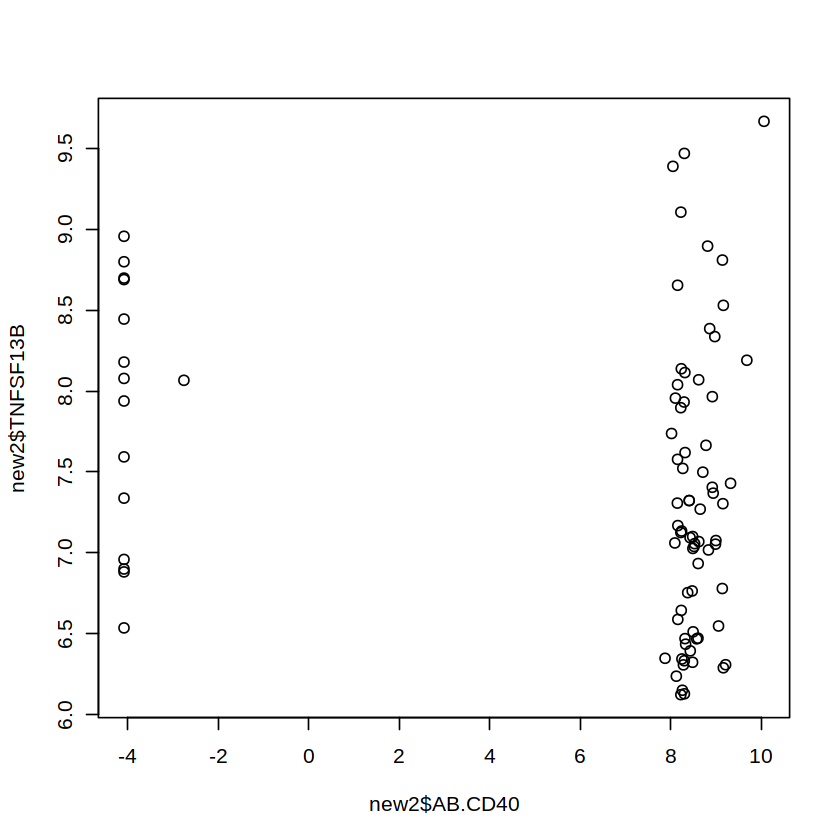

In [43]:
plot(new2$AB.CD40,new2$TNFSF13B)


In [44]:
long_df2<-reshape2::melt(new2)


Using sample_id, individual_id as id variables



In [45]:
rec<-"AB.CD40"
lig<-"TNFSF13B"


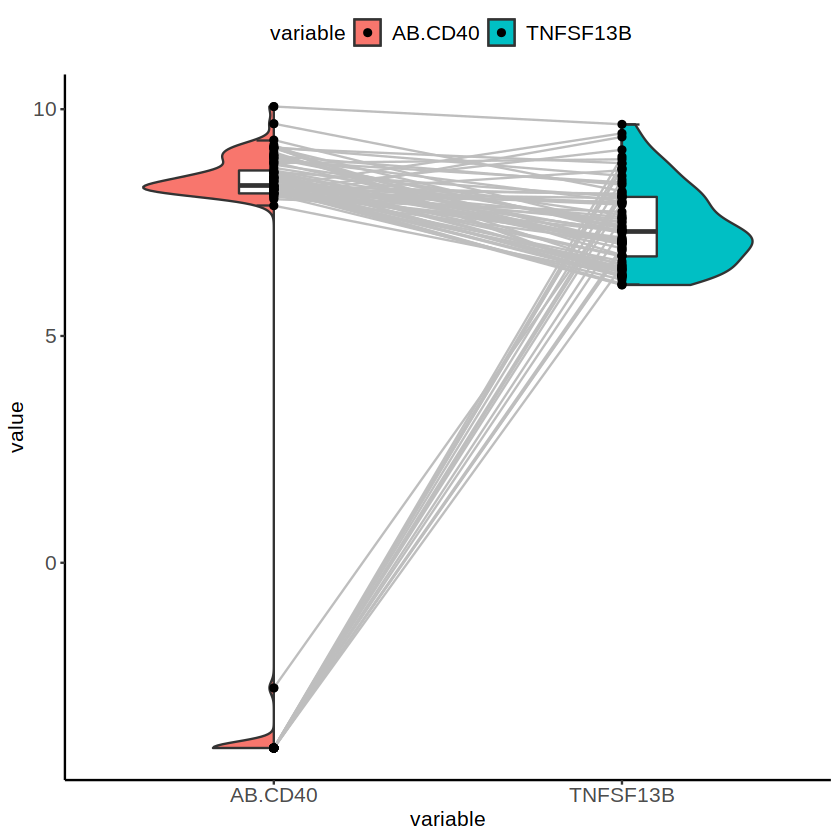

In [53]:

ggplot(data.frame(long_df2[long_df2$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df2) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df2) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df2) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df2) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")


In [47]:

cal_z_score <- function(x){
  (x - mean(x,na.rm=TRUE)) / sd(x,na.rm=TRUE)
}


In [48]:

new2[,2:574] <- apply(new2[,2:574], 2, cal_z_score)


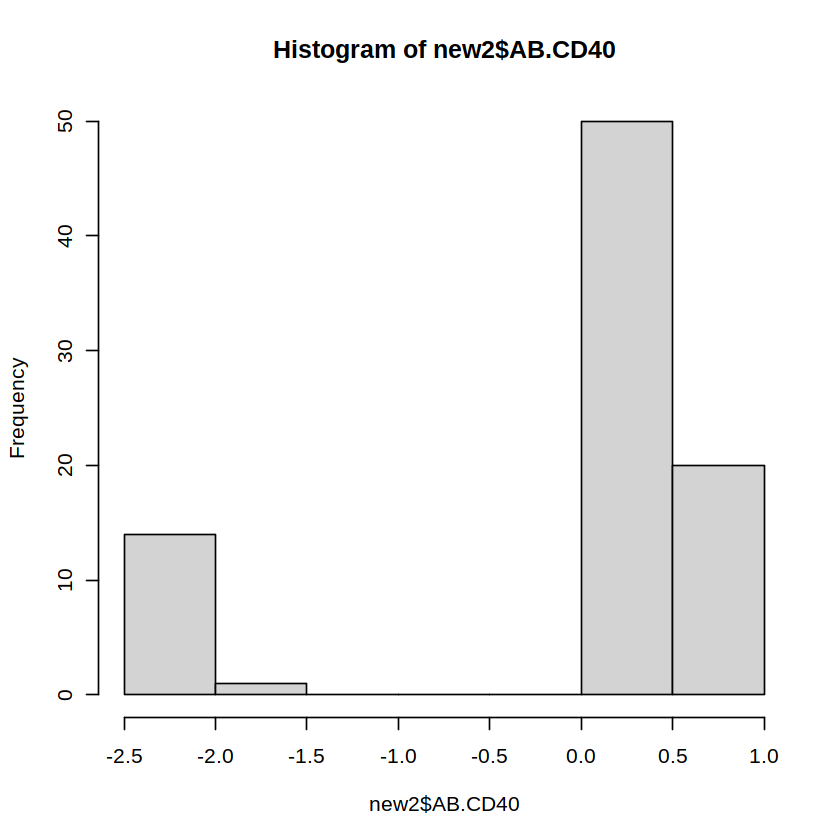

In [50]:
hist(new2$AB.CD40)

In [49]:

long_df3<-reshape2::melt(new2)



Using sample_id, individual_id as id variables



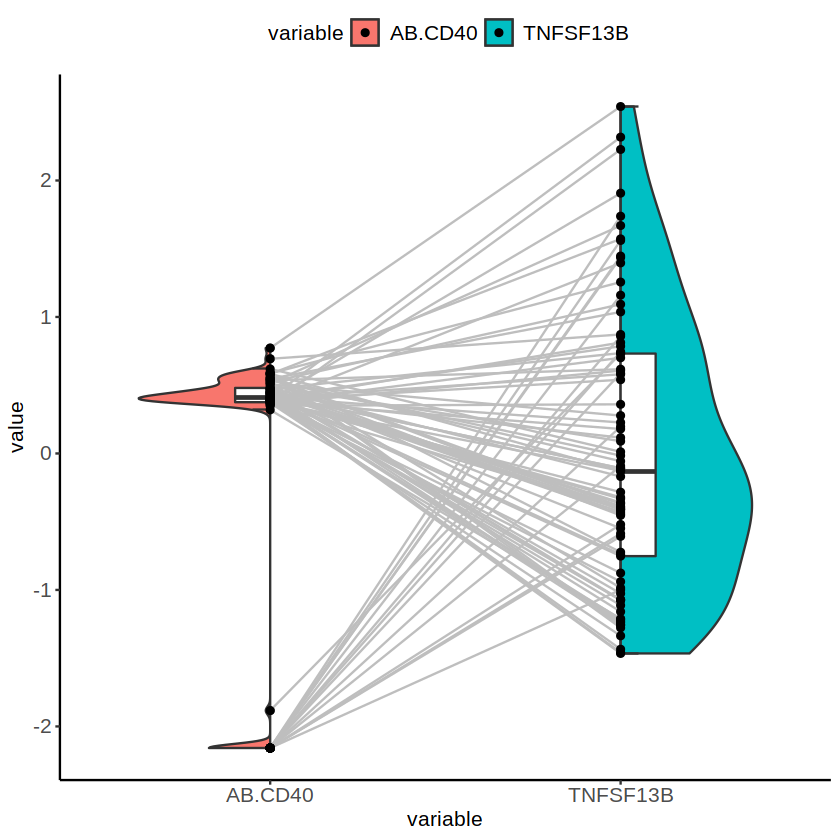

In [52]:

ggplot(data.frame(long_df3[long_df3$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df3) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df3) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df3) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df3) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")


In [17]:
tmp4<-data.frame(t(cpm))


In [18]:
tmp4$sample_id<-rownames(tmp4)


In [19]:
wide_olink<-dcast(olink,Original_SampleID~GeneID,value.var="NPX")
names(wide_olink)[1]<-"sample_id"


Warning message in dcast(olink, Original_SampleID ~ GeneID, value.var = "NPX"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(olink). In the next version, this warning will become an error.”


In [20]:
new3<-merge(tmp4,wide_olink,by="sample_id",all.x=TRUE)
head(new3)
dim(new3)


sample_id AB.ADGRG1 AB.ANPEP  AB.B3GAT1 AB.BTLA  AB.C5AR1 AB.CCR4  AB.CCR5  
1 C103_2204 1647.6840  534.3104 5512.309  2571.450 1988.472 544.9530 1807.6355
2 C104_2204 1200.7524 1103.2940 5136.250  1656.997 2751.482 367.0167 1523.7662
3 C106_2204 2569.8387  893.4297 7452.771  1750.780 1551.977 635.9325  499.9879
4 C113_0605  647.1461  506.5555 1753.349  3354.469 1428.907 379.6954  476.8880
5 C113_2304  510.6509  342.6520 2539.822  2320.406 1100.372 628.0917  628.5989
6 C113_2904  469.4477  591.0259 1152.718  3179.874 1023.476 669.6348  962.6665
  AB.CCR6  AB.CD101 ⋯ TRIM21  TRIM5   TSLP     UMOD    VASN    VCAM1   VEGFA   
1 403.1226 5063.626 ⋯ 2.42722 2.73218  1.73733 0.63036 2.10298 5.72934 13.16634
2 303.4109 5930.615 ⋯ 3.02218 2.64737 -0.22372 0.61822 2.46803 5.61442 13.13383
3 271.5619 5533.324 ⋯ 2.39754 2.41437  0.81331 0.58710 2.46791 5.48022 13.19553
4 545.8827 1475.415 ⋯ 2.39262 2.88367  0.98505 0.47552 2.81779 6.11572 12.99018
5 978.1839 1017.923 ⋯ 3.19469 2.61469  1.22499 0.89623 2.66852 6.77634 13.14894
6 451.2962 2298.046 ⋯ 2.50348 2.33191  0.56714 0.85136 2.75854 6.67321 13.22140
  VSIG2   VWF     ZBTB16 
1 6.84396 7.64381 2.39522
2 7.12135 5.09707 2.07063
3 7.78474 7.25253 1.88304
4 6.36287 6.49356 3.00130
5 6.18068 6.40599 1.98728
6 6.30056 6.88699 2.66870

[1]  85 574

In [21]:
new3$individual_id<-gsub("_[0-9]+","",new3$sample_id)


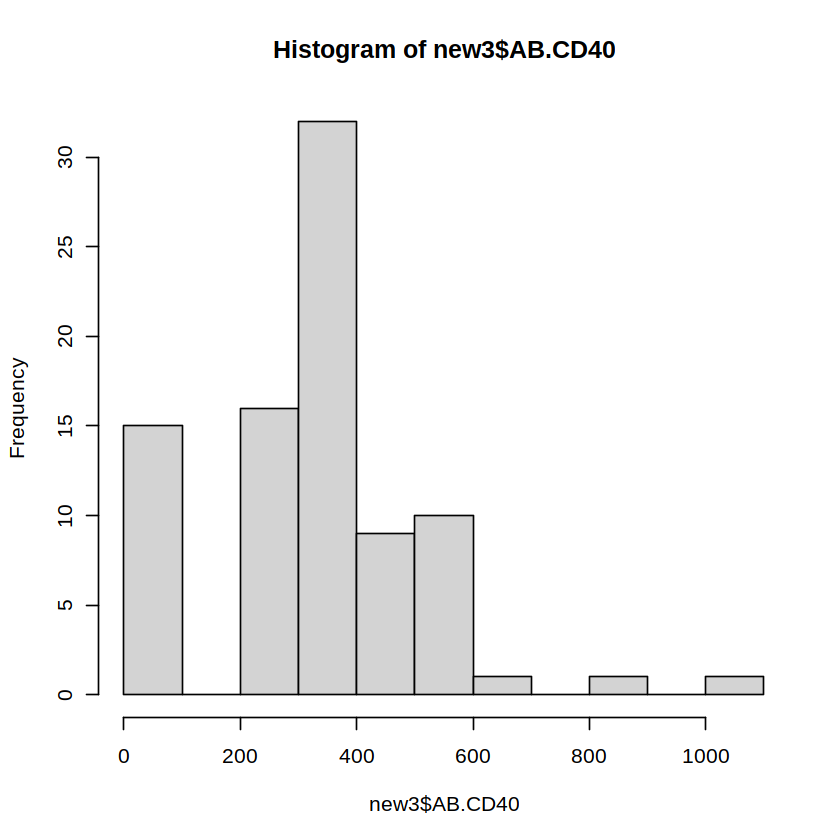

In [22]:
hist(new3$AB.CD40)


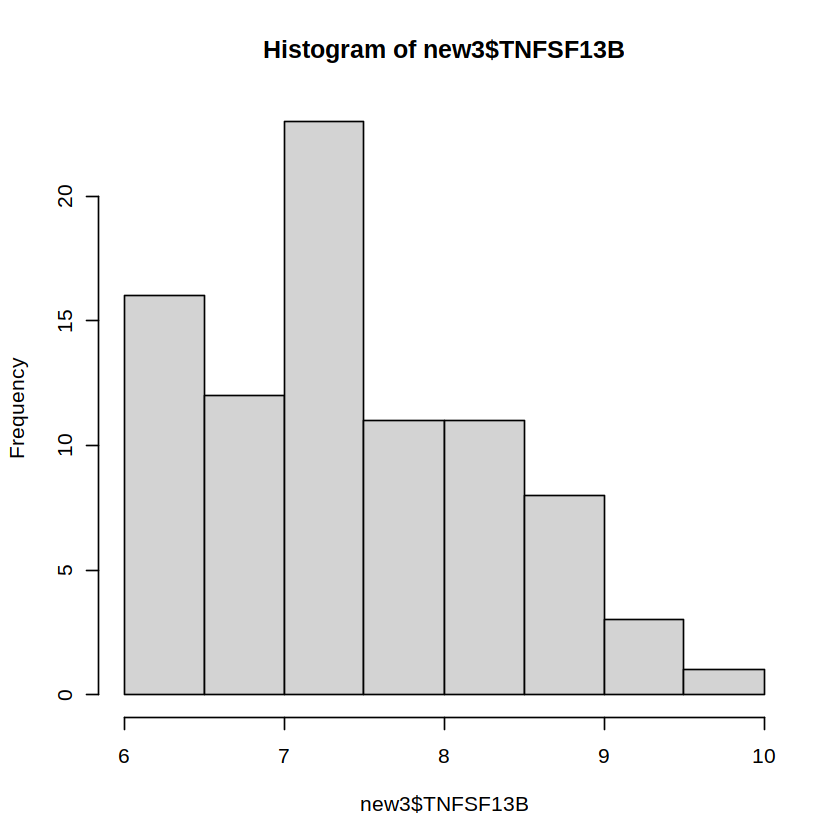

In [23]:
hist(new3$TNFSF13B)


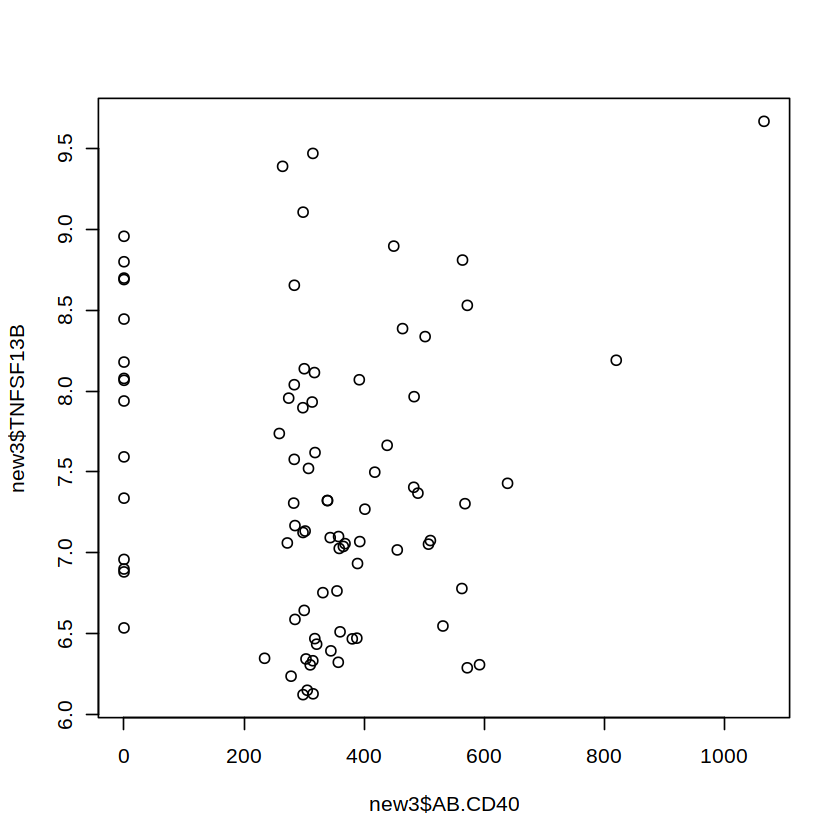

In [24]:
plot(new3$AB.CD40,new3$TNFSF13B)


In [25]:
long_df4<-reshape2::melt(new3)
rec<-"AB.CD40"
lig<-"TNFSF13B"


Using sample_id, individual_id as id variables



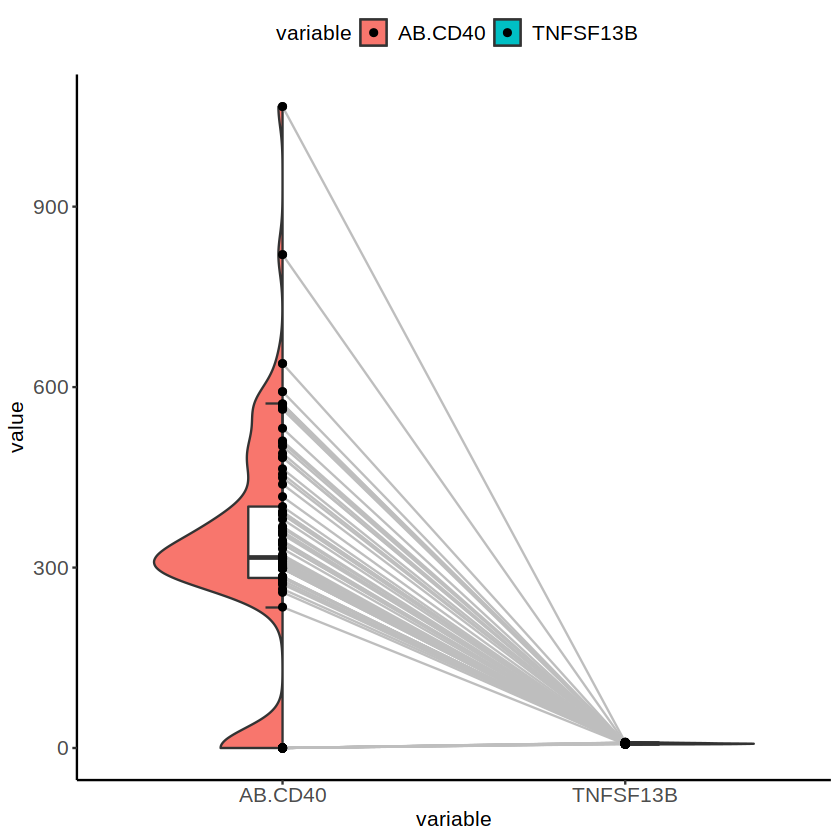

In [26]:

ggplot(data.frame(long_df4[long_df4$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df4) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df4) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df4) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df4) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")


In [27]:
cal_z_score <- function(x){
  (x - mean(x,na.rm=TRUE)) / sd(x,na.rm=TRUE)
}

new3[,2:574] <- apply(new3[,2:574], 2, cal_z_score)


In [28]:
long_df5<-reshape2::melt(new3)


Using sample_id, individual_id as id variables



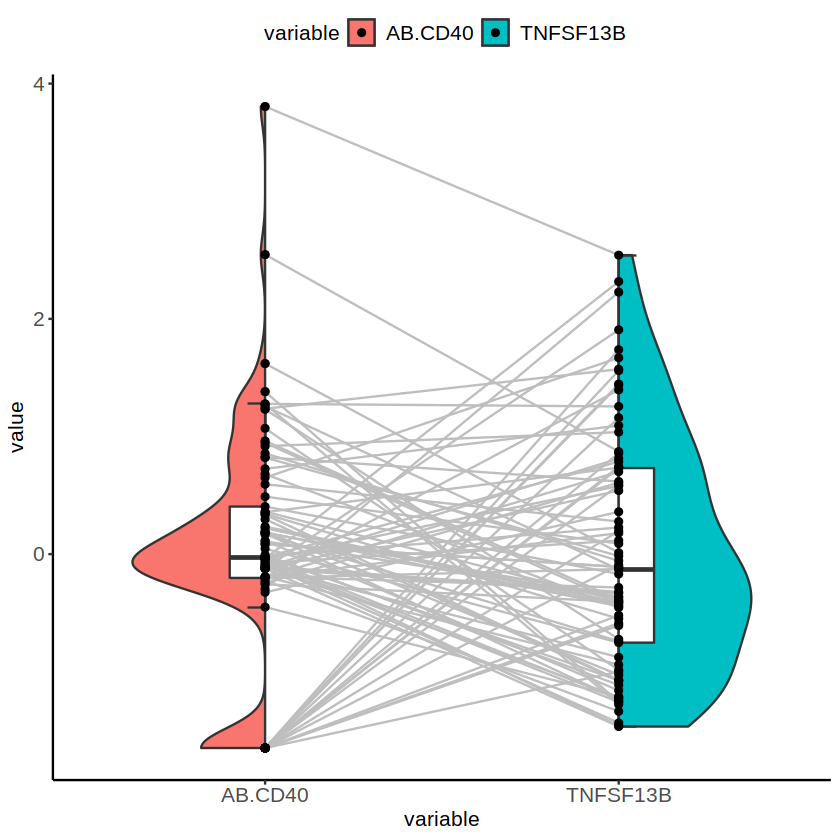

In [29]:

ggplot(data.frame(long_df5[long_df5$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df5) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df5) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df5) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df5) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=12),
         axis.title=element_text(size=12),
         legend.text=element_text(size=12),
         legend.title=element_text(size=12),
         legend.position="top")



In [ ]:
#############
# testing zscores
###############

In [170]:
dim(new)

[1]  85 575

In [171]:
cal_z_score <- function(x){
  (x - mean(x,na.rm=TRUE)) / sd(x,na.rm=TRUE)
}

new[,2:574] <- apply(new[,2:574], 2, cal_z_score)


In [172]:
head(new)

sample_id AB.ADGRG1 AB.ANPEP  AB.B3GAT1   AB.BTLA   AB.C5AR1  AB.CCR4  
1 C103_2204 0.5540380 0.4661512 -0.24945334 0.4975083 0.5782361 0.3235895
2 C104_2204 0.4710925 0.6724028 -0.29551022 0.3836102 0.6704566 0.1747466
3 C106_2204 0.6705515 0.6123853 -0.05286658 0.3978789 0.5078625 0.3817263
4 C113_0605 0.3090625 0.4509780 -0.99606200 0.5664039 0.4844027 0.1875343
5 C113_2304 0.2469700 0.3397867 -0.75452863 0.4708836 0.4102180 0.3770547
6 C113_2904 0.2249185 0.4948470 -1.26942488 0.5525503 0.3896481 0.4011716
  AB.CCR5      AB.CCR6   AB.CD101  ⋯ TRIM5       TSLP        UMOD      
1  0.477063466 0.3941059 0.6284796 ⋯ -0.29930006  1.63456851 -0.7484055
2  0.413452979 0.2948954 0.6689562 ⋯ -0.42514178 -2.39782381 -0.8104275
3 -0.001464451 0.2561773 0.6511979 ⋯ -0.77086893 -0.26543973 -0.9694165
4 -0.019075967 0.4999584 0.3126658 ⋯ -0.07451805  0.08769918 -1.5394673
5  0.083764386 0.7036302 0.2176084 ⋯ -0.47363261  0.58107376  0.6098973
6  0.242459142 0.4335197 0.4261497 ⋯ -0.89322371 -0.77162469  0.3806610
  VASN       VCAM1      VEGFA       VSIG2       VWF        ZBTB16     
1 -1.1181589 -0.5743795 -0.26936293  0.03149137  0.8501718 -0.59898915
2  0.1612484 -0.7913704 -0.42629557  0.47354213 -2.0479434 -0.93681912
3  0.1608278 -1.0447656 -0.12845663  1.53072534  0.4049067 -1.13206088
4  1.3870681  0.1551798 -1.11972446 -0.73517722 -0.4587789  0.03181273
5  0.8639148  1.4025565 -0.35335640 -1.02551655 -0.5584309 -1.02356895
6  1.1794119  1.2078273 -0.00357668 -0.83447489 -0.0110671 -0.31435396
  individual_id
1 C103         
2 C104         
3 C106         
4 C113         
5 C113         
6 C113

In [108]:
#needs to be in long to plot
# want case/control + severity status
#meta<-

In [109]:
#head(colData(smrzd))

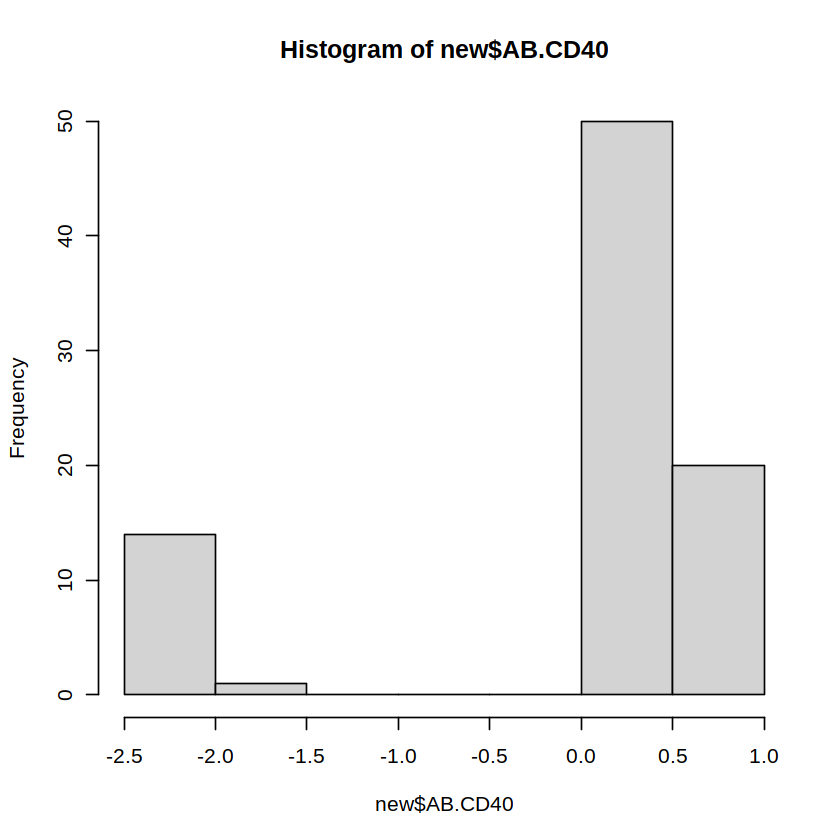

In [173]:
hist(new$AB.CD40)

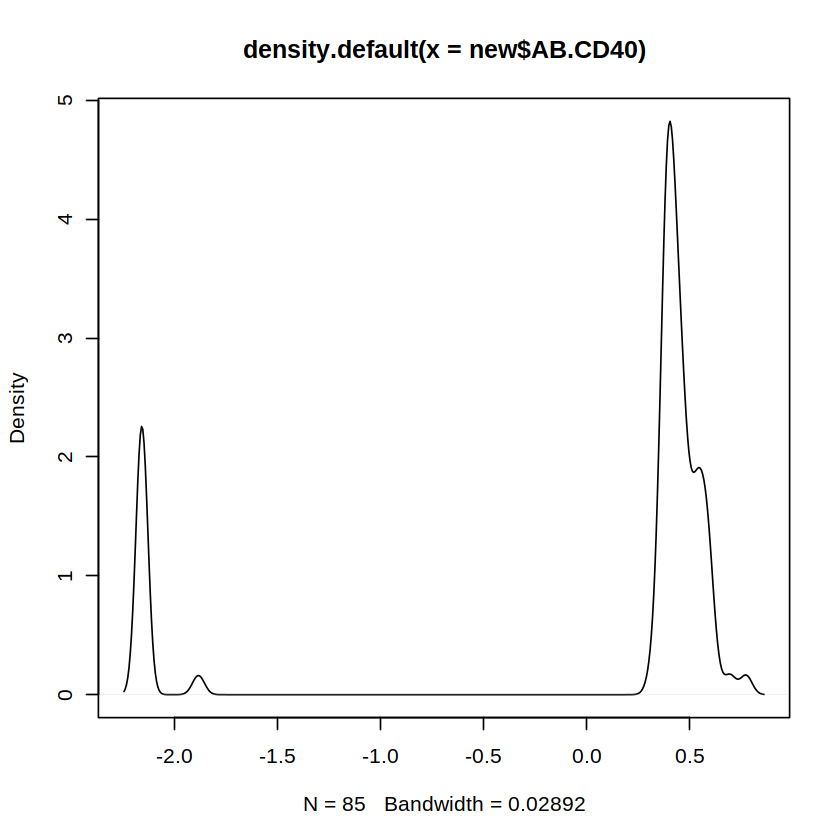

In [174]:
plot(density(new$AB.CD40))

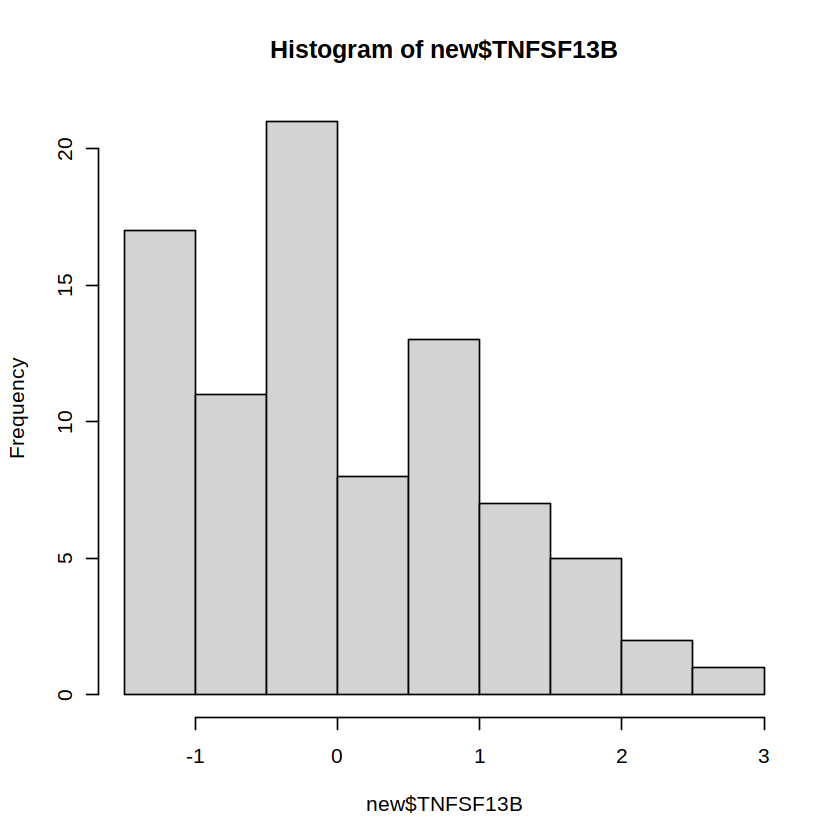

In [175]:
hist(new$TNFSF13B)

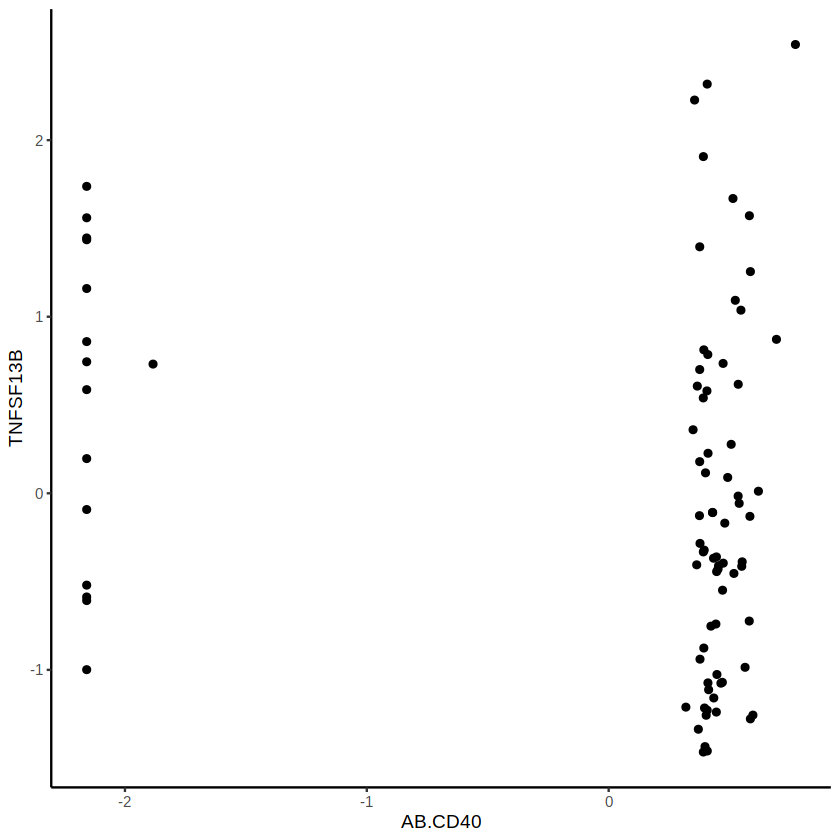

In [176]:
ggplot(new,aes(x=AB.CD40,y=TNFSF13B))+
    geom_point()+
    theme_classic()

In [177]:
"patient_id"%in%names(colData(smrzd))

[1] TRUE

In [178]:
"WHO_temp_severity_group"%in%names(colData(smrzd))

[1] FALSE

In [179]:
smrzd$WHO_temp_severity_group <- factor(smrzd$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))


In [180]:
meta<-colData(smrzd)[,c("sample_id","patient_id","case_control","WHO_temp_severity","WHO_temp_severity_group")]

In [181]:
head(meta)

DataFrame with 6 rows and 5 columns
            sample_id  patient_id case_control WHO_temp_severity
          <character> <character>  <character>       <character>
C103_2204   C103_2204        C103     NEGATIVE                NA
C104_2204   C104_2204        C104     NEGATIVE                NA
C106_2204   C106_2204        C106     NEGATIVE                NA
C113_0605   C113_0605        C113     POSITIVE          moderate
C113_2304   C113_2304        C113     POSITIVE            severe
C113_2904   C113_2904        C113     POSITIVE            severe
          WHO_temp_severity_group
                         <factor>
C103_2204         NA             
C104_2204         NA             
C106_2204         NA             
C113_0605         mild_moderate  
C113_2304         severe_critical
C113_2904         severe_critical

In [182]:
dim(meta)

[1] 85  5

In [183]:
dim(new)
#dim(new_df)

[1]  85 575

In [184]:
long_df<-reshape2::melt(new) #measure.vars=colnames(new)[!colnames(new)%in%c("sample_id","individual_id")],,id.vars=c("sample_id","patient_id","case_control","WHO_temp_severity_group")


Using sample_id, individual_id as id variables



In [185]:
head(long_df)

sample_id individual_id variable  value    
1 C103_2204 C103          AB.ADGRG1 0.5540380
2 C104_2204 C104          AB.ADGRG1 0.4710925
3 C106_2204 C106          AB.ADGRG1 0.6705515
4 C113_0605 C113          AB.ADGRG1 0.3090625
5 C113_2304 C113          AB.ADGRG1 0.2469700
6 C113_2904 C113          AB.ADGRG1 0.2249185

In [186]:
dim(long_df)

[1] 48705     4

In [187]:
long_df<-merge(long_df,meta,by="sample_id")
head(long_df)
dim(long_df)

DataFrame with 6 rows and 8 columns
    sample_id individual_id  variable     value  patient_id case_control
  <character>   <character>  <factor> <numeric> <character>  <character>
1   C103_2204          C103 AB.ADGRG1  0.554038        C103     NEGATIVE
2   C103_2204          C103 FAS       -0.249490        C103     NEGATIVE
3   C103_2204          C103 SIRT2     -1.214846        C103     NEGATIVE
4   C103_2204          C103 PROC       0.849221        C103     NEGATIVE
5   C103_2204          C103 CD4        0.160521        C103     NEGATIVE
6   C103_2204          C103 CD93      -0.236535        C103     NEGATIVE
  WHO_temp_severity WHO_temp_severity_group
        <character>                <factor>
1                NA                      NA
2                NA                      NA
3                NA                      NA
4                NA                      NA
5                NA                      NA
6                NA                      NA

[1] 48705     8

In [188]:
head(long_df[long_df$variable%in%c("AB.CD40","TNFSF13B"),])

DataFrame with 6 rows and 8 columns
    sample_id individual_id variable     value  patient_id case_control
  <character>   <character> <factor> <numeric> <character>  <character>
1   C103_2204          C103 AB.CD40   0.581259        C103     NEGATIVE
2   C103_2204          C103 TNFSF13B -0.723513        C103     NEGATIVE
3   C104_2204          C104 AB.CD40   0.445151        C104     NEGATIVE
4   C104_2204          C104 TNFSF13B -1.239007        C104     NEGATIVE
5   C106_2204          C106 TNFSF13B  0.115895        C106     NEGATIVE
6   C106_2204          C106 AB.CD40   0.400423        C106     NEGATIVE
  WHO_temp_severity WHO_temp_severity_group
        <character>                <factor>
1                NA                      NA
2                NA                      NA
3                NA                      NA
4                NA                      NA
5                NA                      NA
6                NA                      NA

In [189]:
table(long_df$individual_id)


C103 C104 C106 C113 C123 C124 C126 C127 C128 C132 C134 C142 C152 C161 C164 C167 
 573  573  573 1719 1719 1719 1719 1719 1719 1719  573  573  573  573  573  573 
C193 C195 C196 C197  C20  C21 C212 C214 C224  C23 C234 C237 C238 C240 C246 C251 
 573  573  573  573 1719 1719  573  573  573 1719  573  573  573  573  573  573 
 C31  C34  C36  C40  C42  C60  C63  C65  C69  C73  C82  C85  C93 
1719 1719 1719 1719 1719 1719 1719 1719  573 1146 1146  573 1719 

In [190]:
rec<-"AB.CD40"
lig<-"TNFSF13B"

In [191]:
do_plots<-function(x){
    rec<-paste0("AB.",x[[1]])
    lig<-x[[2]]
    print(rec)
    print(lig)
    #all
    ggplot(data.frame(long_df[long_df$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    theme_classic()+
    theme(axis.text=element_text(size=6),
         axis.title=element_text(size=6),
         legend.text=element_text(size=6),
         legend.title=element_text(size=6),
         legend.position="top")
    ggsave(paste0("all_",sub("AB.","AB_",rec),"_",lig,".pdf"),width=4,height=4)
    #case control
    ggplot(data.frame(long_df[long_df$variable%in%c(rec,lig),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    facet_wrap(~case_control)+ #,scale="free_y"
    theme_classic()+
    theme(axis.text=element_text(size=6),
          axis.title=element_text(size=6),
         legend.text=element_text(size=6),
         legend.title=element_text(size=6),
         legend.position="top")
    ggsave(paste0("case_control_",sub("AB.","AB_",rec),"_",lig,".pdf"),width=4,height=4)
    #severity 2 groups
    ggplot(data.frame(long_df[long_df$variable%in%c(rec,lig) & !is.na(long_df$WHO_temp_severity_group),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable==rec),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable==lig),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable==rec),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable==lig),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(group=sample_id))+ #colour=variable,
    facet_wrap(~WHO_temp_severity_group)+ #,scale="free_y"
    theme_classic()+
    theme(axis.text=element_text(size=6),
          axis.title=element_text(size=6),
         legend.text=element_text(size=6),
         legend.title=element_text(size=6),
         legend.position="top")
    ggsave(paste0("severity_2_groups_",sub("AB.","AB_",rec),"_",lig,".pdf"),width=4,height=4)

    #severity 4 groups
    long_df$WHO_temp_severity<-factor(long_df$WHO_temp_severity,levels=c("mild","moderate","severe","critical"))

    ggplot(data.frame(long_df[long_df$variable%in%c(rec,lig) & !is.na(long_df$WHO_temp_severity_group),]),aes(x=variable,y=value))+ #
        geom_half_violin(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable==rec),aes(fill=variable),side="l")+
        geom_half_violin(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable==lig),aes(fill=variable),side="r")+
        geom_half_boxplot(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable==rec),side="l",width=0.2)+
        geom_half_boxplot(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable==lig),side="r",width=0.2)+
        geom_line(aes(group=sample_id),colour="grey")+
        geom_point(aes(group=sample_id))+ #colour=variable,
        facet_wrap(~WHO_temp_severity,nrow=1)+ #,scale="free_y",nrow=1
        theme_classic()+
        theme(axis.text=element_text(size=6),
              axis.title=element_text(size=6),
             legend.text=element_text(size=6),
             legend.title=element_text(size=6),
             legend.position="top")
    ggsave(paste0("severity_4_groups_",sub("AB.","AB_",rec),"_",lig,".pdf"),width=7,height=4)

}

In [192]:
apply(pairs,1,do_plots)

[1] "AB.BTLA"
[1] "TNFRSF14"
[1] "AB.CCR4"
[1] "CCL5"
[1] "AB.CCR4"
[1] "CCL17"
[1] "AB.CCR5"
[1] "CCL4"
[1] "AB.CCR5"
[1] "CCL3"
[1] "AB.CCR5"
[1] "CCL5"
[1] "AB.CCR5"
[1] "CCL8"
[1] "AB.CCR5"
[1] "CCL7"
[1] "AB.CCR6"
[1] "CCL20"
[1] "AB.CD1D"
[1] "LILRB2"
[1] "AB.CD24"
[1] "SELP"
[1] "AB.CD48"
[1] "CD244"
[1] "AB.PDCD1"
[1] "CD274"
[1] "AB.CD86"
[1] "CD28"


Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


[1] "AB.CD38"
[1] "PECAM1"
[1] "AB.CD40"
[1] "TNFSF13B"
[1] "AB.CD40"
[1] "CD40LG"
[1] "AB.CD44"
[1] "FGF2"


Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


[1] "AB.CD44"
[1] "SPP1"
[1] "AB.CD44"
[1] "LGALS9"
[1] "AB.CD44"
[1] "HGF"
[1] "AB.CD44"
[1] "HBEGF"
[1] "AB.CD44"
[1] "SELE"
[1] "AB.CD47"
[1] "LGALS9"
[1] "AB.CD47"
[1] "SIRPA"
[1] "AB.FCER2"
[1] "CR2"
[1] "AB.CX3CR1"
[1] "CX3CL1"
[1] "AB.CXCR3"
[1] "CXCL9"
[1] "AB.CXCR3"
[1] "CCL19"
[1] "AB.CXCR3"
[1] "CCL20"
[1] "AB.CXCR3"
[1] "CXCL11"
[1] "AB.CXCR3"
[1] "CXCL10"
[1] "AB.CXCR3"
[1] "CXCL12"


Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


[1] "AB.DPP4"
[1] "CXCL9"
[1] "AB.DPP4"
[1] "CCL11"


Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


[1] "AB.DPP4"
[1] "CXCL12"


Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


[1] "AB.DPP4"
[1] "CXCL11"
[1] "AB.DPP4"
[1] "CXCL10"
[1] "AB.DPP4"
[1] "NPPB"
[1] "AB.FAS"
[1] "TNF"
[1] "AB.FCGR2A"
[1] "CXCL9"
[1] "AB.ICAM1"
[1] "AREG"


Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


[1] "AB.ITGAL"
[1] "ICAM1"
[1] "AB.ICOS"
[1] "TNF"
[1] "AB.KIR2DL3"
[1] "CXCL9"
[1] "AB.KLRG1"
[1] "CDH1"
[1] "AB.NCAM1"
[1] "GDNF"
[1] "AB.PDCD1"
[1] "PDCD1LG2"


Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values (stat_half_ydensity).”
Warning message:
“Removed 1 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing non-finite values

[1] "AB.SELL"
[1] "SELPLG"
[1] "AB.SELP"
[1] "SELPLG"
[1] "AB.TFRC"
[1] "TNFSF13B"
[1] "AB.TNFRSF13B"
[1] "TNFSF13B"
[1] "AB.TNFRSF13C"
[1] "TNFSF13B"
[1] "AB.TNFRSF14"
[1] "LTA"
[1] "AB.TNFRSF14"
[1] "TNFSF14"


[1] "severity_4_groups_AB_BTLA_TNFRSF14.pdf"     
 [2] "severity_4_groups_AB_CCR4_CCL5.pdf"         
 [3] "severity_4_groups_AB_CCR4_CCL17.pdf"        
 [4] "severity_4_groups_AB_CCR5_CCL4.pdf"         
 [5] "severity_4_groups_AB_CCR5_CCL3.pdf"         
 [6] "severity_4_groups_AB_CCR5_CCL5.pdf"         
 [7] "severity_4_groups_AB_CCR5_CCL8.pdf"         
 [8] "severity_4_groups_AB_CCR5_CCL7.pdf"         
 [9] "severity_4_groups_AB_CCR6_CCL20.pdf"        
[10] "severity_4_groups_AB_CD1D_LILRB2.pdf"       
[11] "severity_4_groups_AB_CD24_SELP.pdf"         
[12] "severity_4_groups_AB_CD48_CD244.pdf"        
[13] "severity_4_groups_AB_PDCD1_CD274.pdf"       
[14] "severity_4_groups_AB_CD86_CD28.pdf"         
[15] "severity_4_groups_AB_CD38_PECAM1.pdf"       
[16] "severity_4_groups_AB_CD40_TNFSF13B.pdf"     
[17] "severity_4_groups_AB_CD40_CD40LG.pdf"       
[18] "severity_4_groups_AB_CD44_FGF2.pdf"         
[19] "severity_4_groups_AB_CD44_SPP1.pdf"         
[20] "severity_4_groups_AB_CD44_LGALS9.pdf"       
[21] "severity_4_groups_AB_CD44_HGF.pdf"          
[22] "severity_4_groups_AB_CD44_HBEGF.pdf"        
[23] "severity_4_groups_AB_CD44_SELE.pdf"         
[24] "severity_4_groups_AB_CD47_LGALS9.pdf"       
[25] "severity_4_groups_AB_CD47_SIRPA.pdf"        
[26] "severity_4_groups_AB_FCER2_CR2.pdf"         
[27] "severity_4_groups_AB_CX3CR1_CX3CL1.pdf"     
[28] "severity_4_groups_AB_CXCR3_CXCL9.pdf"       
[29] "severity_4_groups_AB_CXCR3_CCL19.pdf"       
[30] "severity_4_groups_AB_CXCR3_CCL20.pdf"       
[31] "severity_4_groups_AB_CXCR3_CXCL11.pdf"      
[32] "severity_4_groups_AB_CXCR3_CXCL10.pdf"      
[33] "severity_4_groups_AB_CXCR3_CXCL12.pdf"      
[34] "severity_4_groups_AB_DPP4_CXCL9.pdf"        
[35] "severity_4_groups_AB_DPP4_CCL11.pdf"        
[36] "severity_4_groups_AB_DPP4_CXCL12.pdf"       
[37] "severity_4_groups_AB_DPP4_CXCL11.pdf"       
[38] "severity_4_groups_AB_DPP4_CXCL10.pdf"       
[39] "severity_4_groups_AB_DPP4_NPPB.pdf"         
[40] "severity_4_groups_AB_FAS_TNF.pdf"           
[41] "severity_4_groups_AB_FCGR2A_CXCL9.pdf"      
[42] "severity_4_groups_AB_ICAM1_AREG.pdf"        
[43] "severity_4_groups_AB_ITGAL_ICAM1.pdf"       
[44] "severity_4_groups_AB_ICOS_TNF.pdf"          
[45] "severity_4_groups_AB_KIR2DL3_CXCL9.pdf"     
[46] "severity_4_groups_AB_KLRG1_CDH1.pdf"        
[47] "severity_4_groups_AB_NCAM1_GDNF.pdf"        
[48] "severity_4_groups_AB_PDCD1_PDCD1LG2.pdf"    
[49] "severity_4_groups_AB_SELL_SELPLG.pdf"       
[50] "severity_4_groups_AB_SELP_SELPLG.pdf"       
[51] "severity_4_groups_AB_TFRC_TNFSF13B.pdf"     
[52] "severity_4_groups_AB_TNFRSF13B_TNFSF13B.pdf"
[53] "severity_4_groups_AB_TNFRSF13C_TNFSF13B.pdf"
[54] "severity_4_groups_AB_TNFRSF14_LTA.pdf"      
[55] "severity_4_groups_AB_TNFRSF14_TNFSF14.pdf"

In [ ]:
#check odd results

In [163]:
"AB.BTLA"%in%names(new)

[1] TRUE

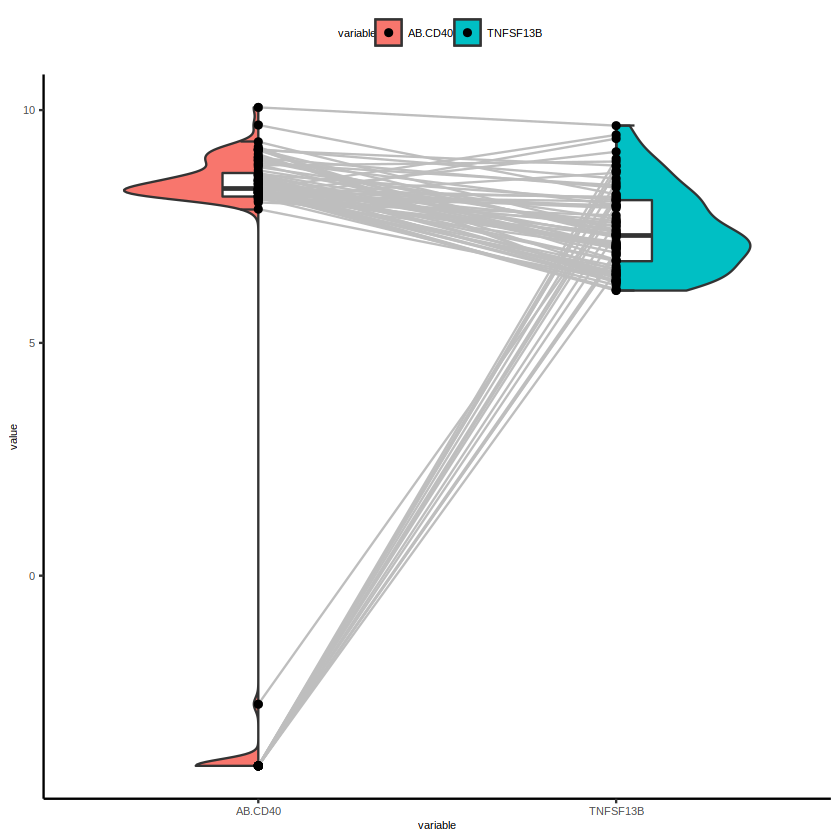

In [145]:



ggplot(data.frame(long_df[long_df$variable%in%c("AB.CD40","TNFSF13B"),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df) %>% filter(variable=="AB.CD40"),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df) %>% filter(variable=="TNFSF13B"),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df) %>% filter(variable=="AB.CD40"),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df) %>% filter(variable=="TNFSF13B"),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    #facet_wrap(~case_control)+
    theme_classic()+
    theme(axis.text=element_text(size=6),
          axis.title=element_text(size=6),
         legend.text=element_text(size=6),
         legend.title=element_text(size=6),
         legend.position="top")
ggsave("all_CD40_TNFSF13B.pdf",width=4,height=4)


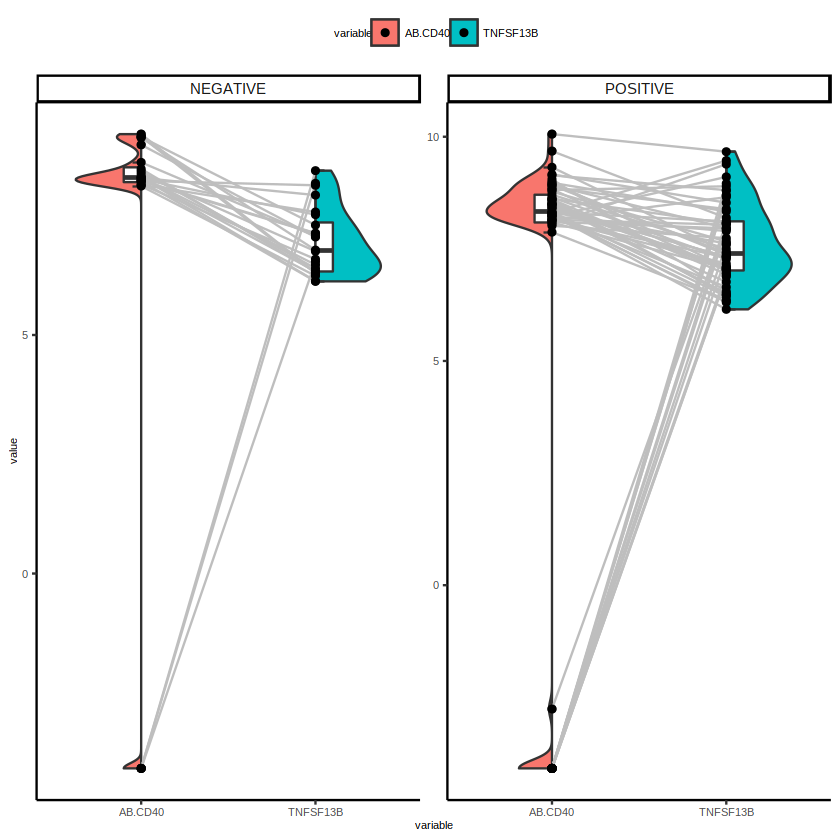

In [144]:
ggplot(data.frame(long_df[long_df$variable%in%c("AB.CD40","TNFSF13B"),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df) %>% filter(variable=="AB.CD40"),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df) %>% filter(variable=="TNFSF13B"),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df) %>% filter(variable=="AB.CD40"),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df) %>% filter(variable=="TNFSF13B"),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(fill=variable,group=sample_id))+
    facet_wrap(~case_control,scale="free_y")+
    theme_classic()+
    theme(axis.text=element_text(size=6),
          axis.title=element_text(size=6),
         legend.text=element_text(size=6),
         legend.title=element_text(size=6),
         legend.position="top")
ggsave("case_control_CD40_TNFSF13B.pdf",width=4,height=4)


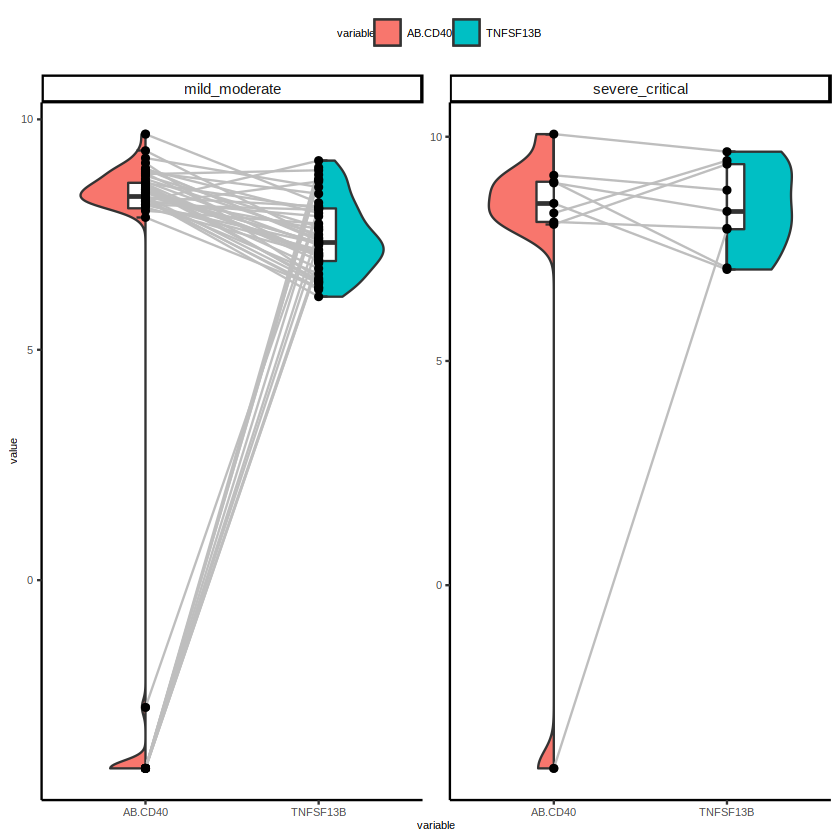

In [143]:
ggplot(data.frame(long_df[long_df$variable%in%c("AB.CD40","TNFSF13B") & !is.na(long_df$WHO_temp_severity_group),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable=="AB.CD40"),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable=="TNFSF13B"),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable=="AB.CD40"),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable=="TNFSF13B"),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(group=sample_id))+ #colour=variable,
    facet_wrap(~WHO_temp_severity_group,scale="free_y")+
    theme_classic()+
    theme(axis.text=element_text(size=6),
          axis.title=element_text(size=6),
         legend.text=element_text(size=6),
         legend.title=element_text(size=6),
         legend.position="top")
ggsave("severity_2_groups_CD40_TNFSF13B.pdf",width=4,height=4)


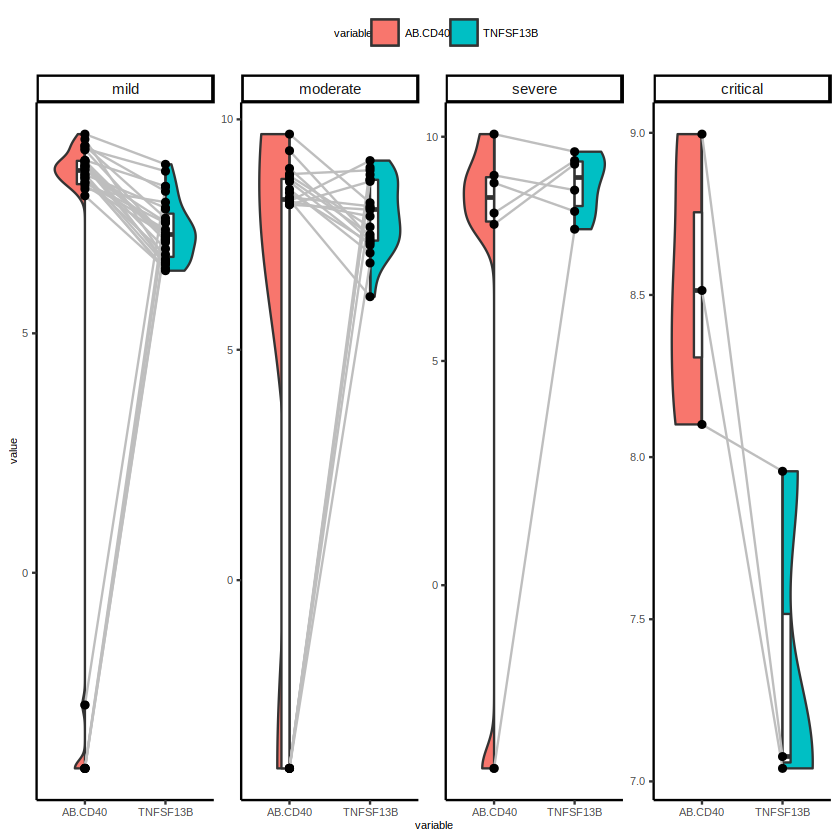

In [141]:
long_df$WHO_temp_severity<-factor(long_df$WHO_temp_severity,levels=c("mild","moderate","severe","critical"))

ggplot(data.frame(long_df[long_df$variable%in%c("AB.CD40","TNFSF13B") & !is.na(long_df$WHO_temp_severity_group),]),aes(x=variable,y=value))+ #
    geom_half_violin(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable=="AB.CD40"),aes(fill=variable),side="l")+
    geom_half_violin(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable=="TNFSF13B"),aes(fill=variable),side="r")+
    geom_half_boxplot(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable=="AB.CD40"),side="l",width=0.2)+
    geom_half_boxplot(data = data.frame(long_df[!is.na(long_df$WHO_temp_severity_group),]) %>% filter(variable=="TNFSF13B"),side="r",width=0.2)+
    geom_line(aes(group=sample_id),colour="grey")+
    geom_point(aes(group=sample_id))+ #colour=variable,
    facet_wrap(~WHO_temp_severity,scale="free_y",nrow=1)+
    theme_classic()+
    theme(axis.text=element_text(size=6),
          axis.title=element_text(size=6),
         legend.text=element_text(size=6),
         legend.title=element_text(size=6),
         legend.position="top")
ggsave("severity_4_groups_CD40_TNFSF13B.pdf",width=7,height=4)


In [217]:
data

class: SingleCellExperiment 
dim: 137 371084 
metadata(0):
assays(3): counts logcounts scaledata
rownames(137): AB-ADGRG1 AB-ANPEP ... AB-TCRVd2 AB-IgL
rowData names(0):
colnames(371084): UK-CIC10689738+UK-CIC10690026_AAACCTGAGGCAATTA-1
  UK-CIC10689738+UK-CIC10690026_AAACCTGCAAGCCGCT-1 ...
  UK-CIC10689787+UK-CIC10690075_TTTGTCAGTTGTGGCC-1
  UK-CIC10689787+UK-CIC10690075_TTTGTCATCAAACAAG-1
colData names(603): orig.ident nCount_RNA ... ZBTB16 ident
reducedDimNames(1): APCA
mainExpName: ADT
altExpNames(1): RNA

In [220]:
smrzd

class: SingleCellExperiment 
dim: 137 85 
metadata(0):
assays(2): counts logcounts
rownames(137): AB-ADGRG1 AB-ANPEP ... AB-TCRVd2 AB-IgL
rowData names(0):
colnames(85): C103_2204 C104_2204 ... C93_2104 C93_2704
colData names(607): orig.ident nCount_RNA ... WHO_temp_severity_group
  sizeFactor
reducedDimNames(1): APCA
mainExpName: ADT
altExpNames(1): RNA

In [219]:
smrzd <- scuttle::logNormCounts(smrzd)

In [ ]:
##############
# Check correlation results are the same with logcounts
############# 

In [221]:
tmp<-data.frame(t(logcounts(smrzd)))


In [222]:
head(tmp)
dim(tmp)

AB.ADGRG1 AB.ANPEP AB.B3GAT1 AB.BTLA  AB.C5AR1 AB.CCR4  AB.CCR5 
C103_2204 15.76000  14.13537 17.50220  16.40213 16.03122 14.16382 15.89366
C104_2204 15.32252  15.20041 17.41927  15.78715 16.51877 13.61258 15.66622
C106_2204 16.14265  14.61843 17.67873  15.58898 15.41509 14.12797 13.78102
C113_0605 14.61476  14.26140 16.05267  16.98863 15.75748 13.84555 14.17434
C113_2304 13.49549  12.91996 15.80971  15.67937 14.60301 13.79411 13.79527
C113_2904 13.97549  14.30773 15.27144  16.73534 15.09988 14.48787 15.01151
          AB.CCR6  AB.CD101 AB.CD14  ⋯ AB.mouse.IgG2a AB.mouse.IgG2b
C103_2204 13.72893 17.37971 13.50939 ⋯ 13.79270       13.57620      
C104_2204 13.33803 17.62674 14.83312 ⋯ 14.22071       13.09464      
C106_2204 12.90049 17.24910 13.37663 ⋯ 12.60764       11.35011      
C113_0605 14.36927 15.80368 12.57029 ⋯ 15.13705       13.66449      
C113_2304 14.43320 14.49065 11.98907 ⋯ 13.77741       12.30109      
C113_2904 13.91860 16.26679 12.89427 ⋯ 14.27943       13.80607      
          AB.rat.IgG2b AB.TCRab AB.rat.IgG1 AB.rat.IgG2a AB.hamster.IgG
C103_2204 12.34380     14.99807 13.62742    13.56256     13.67049      
C104_2204 12.47779     14.27608 12.98907    13.06918     13.15341      
C106_2204 11.16648     15.78979 11.50801    12.35308     11.73484      
C113_0605 12.27428     16.16232 14.03436    14.62073     13.98242      
C113_2304 11.87615     16.23975 12.39062    13.42052     12.64047      
C113_2904 12.81612     16.34265 13.53217    13.70510     13.90172      
          AB.TCRVa7.2 AB.TCRVd2 AB.IgL  
C103_2204 11.63812    13.79739  15.58214
C104_2204 11.86736    12.60714  16.07771
C106_2204 11.04314    12.30642  15.06412
C113_0605 12.76591    13.83787  16.19379
C113_2304 11.22058    12.34916  15.68322
C113_2904 12.13835    12.59663  15.97164

[1]  85 137

In [223]:
tmp$sample_id<-rownames(tmp)

In [224]:
wide_olink<-dcast(olink,Original_SampleID~GeneID,value.var="NPX")


Warning message in dcast(olink, Original_SampleID ~ GeneID, value.var = "NPX"):
“The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(olink). In the next version, this warning will become an error.”


In [225]:


names(wide_olink)[1]<-"sample_id"

new<-merge(tmp,wide_olink,by="sample_id",all.x=TRUE)

head(new)
dim(new)

new$individual_id<-gsub("_[0-9]+","",new$sample_id)


sample_id AB.ADGRG1 AB.ANPEP AB.B3GAT1 AB.BTLA  AB.C5AR1 AB.CCR4  AB.CCR5 
1 C103_2204 15.76000  14.13537 17.50220  16.40213 16.03122 14.16382 15.89366
2 C104_2204 15.32252  15.20041 17.41927  15.78715 16.51877 13.61258 15.66622
3 C106_2204 16.14265  14.61843 17.67873  15.58898 15.41509 14.12797 13.78102
4 C113_0605 14.61476  14.26140 16.05267  16.98863 15.75748 13.84555 14.17434
5 C113_2304 13.49549  12.91996 15.80971  15.67937 14.60301 13.79411 13.79527
6 C113_2904 13.97549  14.30773 15.27144  16.73534 15.09988 14.48787 15.01151
  AB.CCR6  AB.CD101 ⋯ TRIM21  TRIM5   TSLP     UMOD    VASN    VCAM1   VEGFA   
1 13.72893 17.37971 ⋯ 2.42722 2.73218  1.73733 0.63036 2.10298 5.72934 13.16634
2 13.33803 17.62674 ⋯ 3.02218 2.64737 -0.22372 0.61822 2.46803 5.61442 13.13383
3 12.90049 17.24910 ⋯ 2.39754 2.41437  0.81331 0.58710 2.46791 5.48022 13.19553
4 14.36927 15.80368 ⋯ 2.39262 2.88367  0.98505 0.47552 2.81779 6.11572 12.99018
5 14.43320 14.49065 ⋯ 3.19469 2.61469  1.22499 0.89623 2.66852 6.77634 13.14894
6 13.91860 16.26679 ⋯ 2.50348 2.33191  0.56714 0.85136 2.75854 6.67321 13.22140
  VSIG2   VWF     ZBTB16 
1 6.84396 7.64381 2.39522
2 7.12135 5.09707 2.07063
3 7.78474 7.25253 1.88304
4 6.36287 6.49356 3.00130
5 6.18068 6.40599 1.98728
6 6.30056 6.88699 2.66870

[1]  85 574

In [226]:
df<-apply(pairs,1,function(x){
    #print(x[1])
    #print(x[2])
    res<-rmcorr(individual_id,paste0("AB.",x[1]),x[2],new)
    out<-data.frame(cite=paste0("AB.",x[1]),olink=x[2],r=res$r,p=res$p,ciupper=res$CI[2],cilower=res$CI[1])
    return(out)
})



Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_id' coerced into a factor”
Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_id' coerced into a factor”
Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_id' coerced into a factor”
Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_id' coerced into a factor”
Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_id' coerced into a factor”
Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_id' coerced into a factor”
Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_id' coerced into a factor”
Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_id' coerced into a factor”
Warning message in rmcorr(individual_id, paste0("AB.", x[1]), x[2], new):
“'individual_i

In [227]:
df<-do.call(rbind,df)
head(df)
dim(df)


cite    olink    r         p          ciupper   cilower     
ligand  AB.BTLA TNFRSF14 0.2149399 0.17715723 0.4967676 -0.107894247
ligand1 AB.CCR4 CCL5     0.2974000 0.05897562 0.5603379 -0.019993121
ligand2 AB.CCR4 CCL17    0.3080075 0.05009632 0.5682966 -0.008317872
ligand3 AB.CCR5 CCL4     0.1494527 0.35101513 0.4440315 -0.174282640
ligand4 AB.CCR5 CCL3     0.1403357 0.38149760 0.4365242 -0.183297410
ligand5 AB.CCR5 CCL5     0.2885832 0.06727418 0.5536856 -0.029631898

[1] 55  6

In [228]:

df$label<-paste0(gsub("AB.","",(df$cite)),"-",df$olink)

df$protein<-"protein"


In [229]:
order_want<-df[order(df$r),"label"]

df$label<-factor(df$label,levels=order_want)

Saving 5 x 6.67 in image



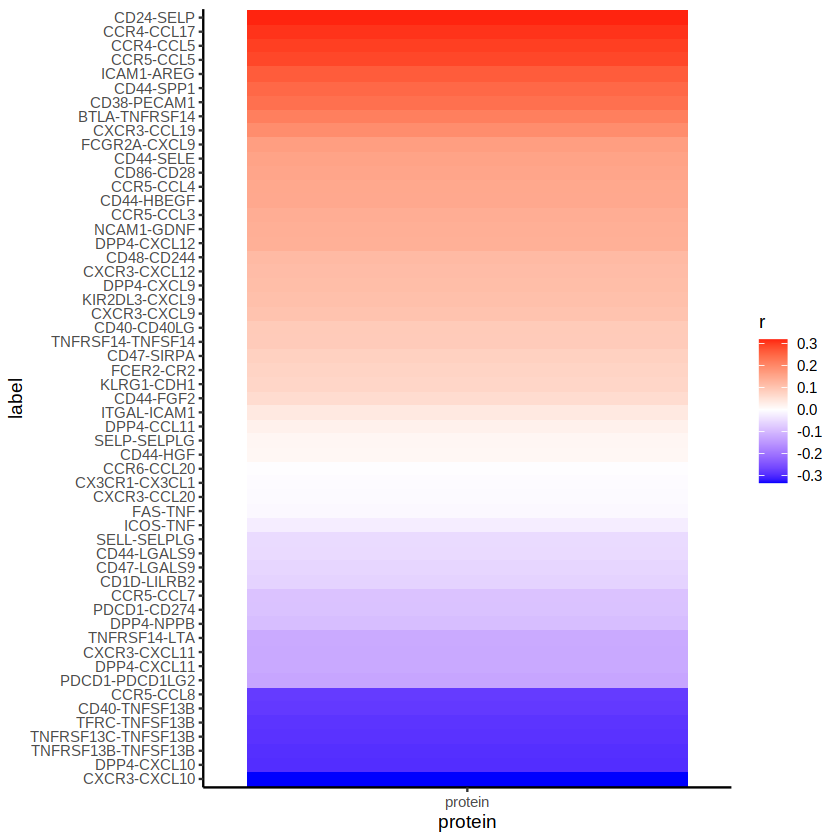

In [230]:
ggplot(df,aes(x=protein,y=label,fill=r))+
    geom_tile()+
    scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0) +
    theme_classic()
ggsave("cite_olink_receptor_ligand_correlation_heatmap_logcounts.pdf",width=5)


In [231]:

df$padj<-p.adjust(df$p, method = "BH", n = length(df$p))


In [232]:
write.table(df,"receptor_ligand_res_logcounts.tsv",col.names=TRUE,row.names=FALSE,quote=FALSE,sep="\t")
